<h1>Narrative Arc Sherlock Holmes</h1>

by David Siegl

In [1]:
import pandas as pd
import nltk
import os
from collections import defaultdict
from collections import Counter
import re
import string
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import f_oneway
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /home/david/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/david/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/david/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/david/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/david/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/david/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

<h2>Preprocessing</h2>

The complete works of Sherlock Holmes were downloaded as individual text files through this website archive https://sherlock-holm.es/.

As a first step of the preprocessing pipeline we read every text file, extract its title, remove some unnecessary lines and finally build a dictionary with the keys corresponding to the respective title and the values to each text accordingly. The created dictionary is then converted into a dataframe.

In [2]:
df_dict = defaultdict(str)
title = None

for f in os.listdir('./data/sherlock/'):
    with open('./data/sherlock/' + f, 'r') as text:
        lines = text.readlines()
        text.seek(0)
        ls = list()
        for number, line in enumerate(lines):
            if number == 4: # extracting the title of each story as a key
                title = line
                title = title.strip()
            elif number not in [4, 6] and line != "\n": # skipping unneccesary lines
                ls.append(line.strip(" "))
            
        conc_text = "".join(ls)
        conc_text = re.sub(r'[-]{10}\n([\S\s]+)', '', conc_text) # removing additional information at the bottom of the text files
        conc_text = conc_text.strip()
        df_dict[title] = conc_text

In [3]:
df_sherlock = pd.DataFrame.from_dict(df_dict, orient='index', columns=['text'])
df_sherlock.index.name = 'title'

Next we apply common preprocessing steps such as punctuation and stopwords removal as well as lemmatisation.

In [4]:
def remove_numeric(text):
    return re.sub(r'\d+', '', text)

df_sherlock['text_prepro'] = df_sherlock['text'].apply(lambda x: remove_numeric(x))

In [5]:
df_sherlock['text_prepro_tok_vader'] = df_sherlock['text_prepro'].apply(lambda x: nltk.tokenize.sent_tokenize(x)) # slightly different preprocessing pipeline for emotion analysis

In [6]:
df_sherlock['text_prepro_ner'] = df_sherlock['text_prepro'].apply(lambda x: nltk.tokenize.word_tokenize(x)) # pipeline for ner

In [7]:
df_sherlock['text_prepro'] = df_sherlock['text_prepro'].str.lower() # default pipeline

In [8]:
translator = str.maketrans('', '', string.punctuation)
df_sherlock['text_prepro'] = df_sherlock['text_prepro'].apply(lambda x: x.translate(translator))

In [9]:
df_sherlock['text_prepro_tok_narrative'] = df_sherlock['text_prepro'].apply(lambda x: nltk.tokenize.word_tokenize(x)) # different pipeline for narrative cohesion analysis

In [10]:
stopwords = nltk.corpus.stopwords.words('english')
df_sherlock['text_prepro'] = df_sherlock['text_prepro'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [11]:
df_sherlock['text_prepro_tok'] = df_sherlock['text_prepro'].apply(lambda x: nltk.tokenize.word_tokenize(x))

In [12]:
# lemmatizer = nltk.stem.WordNetLemmatizer()

# def lem_text(text):
#     lemmed_words = [lemmatizer.lemmatize(word) for word in text]
#     return ' '.join(lemmed_words)

# df_sherlock['text_lemmed_ner'] = df_sherlock['text_prepro_tok'].apply(lem_text)

In addition we also have to segment each text into 5 parts of equal length in order to compute local values for certain points in narrative time which can then be compared according to the notion of a narrative arc. Here we opt for a value of 5 segments because it firstly corresponds to the traditional notion of the dramatic climactic progression of rise and fall and is secondly also supported by the relevant literature which has been consulted beforehand.

In [13]:
def segment_text (text):
    segment_length = len(text) // 5
    segments = [text[i:i+segment_length] for i in range(0, len(text), segment_length)]
    return segments[:5]

df_sherlock['segments_temp'] = df_sherlock['text_prepro_tok'].apply(segment_text)

df_sherlock_segments_temp = df_sherlock.explode('segments_temp')

In [14]:
df_sherlock['segments_vader'] = df_sherlock['text_prepro_tok_vader'].apply(segment_text) 

df_sherlock_segments_vader = df_sherlock.explode('segments_vader')

In [15]:
df_sherlock['segments_narrative'] = df_sherlock['text_prepro_tok_narrative'].apply(segment_text)

df_sherlock_segments_narrative = df_sherlock.explode('segments_narrative')

In [16]:
df_sherlock['segments_ner'] = df_sherlock['text_prepro_ner'].apply(segment_text)

df_sherlock_segments_ner = df_sherlock.explode('segments_ner')

In [17]:
values = list(range(1, 6)) * ((len(df_sherlock_segments_temp) // 5) + 1)

df_sherlock_segments_temp['segment_num'] = values[:len(df_sherlock_segments_temp)]

df_sherlock_segments_vader['segment_num'] = values[:len(df_sherlock_segments_vader)]

df_sherlock_segments_narrative['segment_num'] = values[:len(df_sherlock_segments_narrative)]

df_sherlock_segments_ner['segment_num'] = values[:len(df_sherlock_segments_ner)]

In [18]:
df_sherlock_segments_temp.reset_index(inplace=True)
df_sherlock_segments_narrative.reset_index(inplace=True)
df_sherlock_segments_vader.reset_index(inplace=True)
df_sherlock_segments_ner.reset_index(inplace=True)

<h2> EDA </h2>

In order to obtain a better understanding on the data we first do some basic EDA such as for example the extraction of the distribution of text length throughout the whole dataset which will help with normalisation further down the pipeline.

In [42]:
df_sherlock['word_counts'] = df_sherlock['text'].apply(lambda x: len(x.split()))

<Axes: xlabel='word_counts', ylabel='Count'>

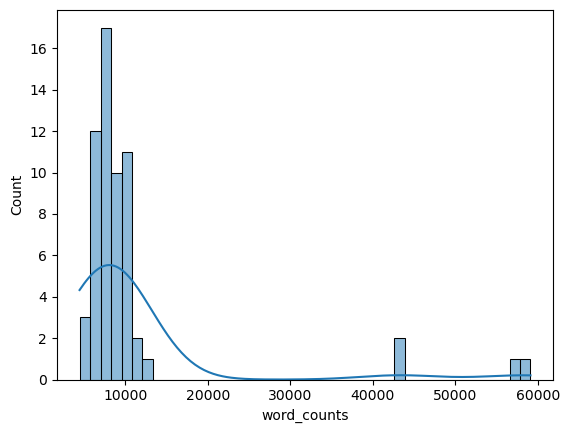

In [43]:
sns.histplot(df_sherlock, x='word_counts', kde=True)

This basic histogram already displays a considerable skew of the data towards shorter stories of around 5000 words, which can be mainly explained by the fact that the original Sherlock Holmes stories were mainly published as a series of short stories within the literature magazine 'The Strand'.

In [44]:
df_sherlock.nlargest(4, 'word_counts')[['word_counts']]

,word_counts
title,
THE HOUND OF THE BASKERVILLES,59108
THE VALLEY OF FEAR,57551
A STUDY IN SCARLET,43379
THE SIGN OF THE FOUR,42998


In [45]:
df_sherlock["avg_sent_len"] = df_sherlock["text"].map(lambda x: np.mean([len(w.split()) for w in nltk.tokenize.sent_tokenize(x)]))

<Axes: xlabel='avg_sent_len', ylabel='Count'>

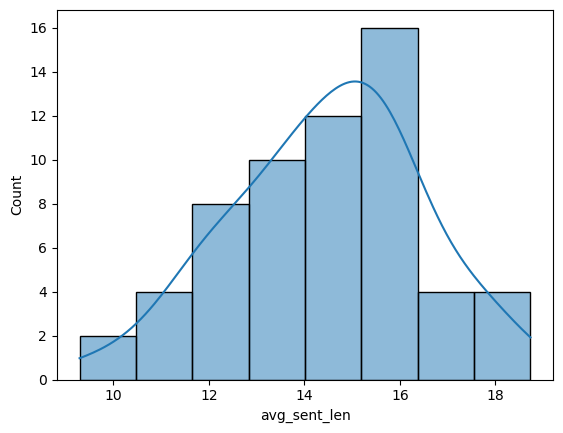

In [46]:
sns.histplot(df_sherlock, x='avg_sent_len', kde=True)

The texts with the most words are unsurpringly the short novels within the corpus.

In [47]:
all_text = ' '.join(df_sherlock['text_lemmed'])
all_text = nltk.word_tokenize(all_text)
 
word_counts = Counter(all_text)
most_common = word_counts.most_common(25)

<Axes: >

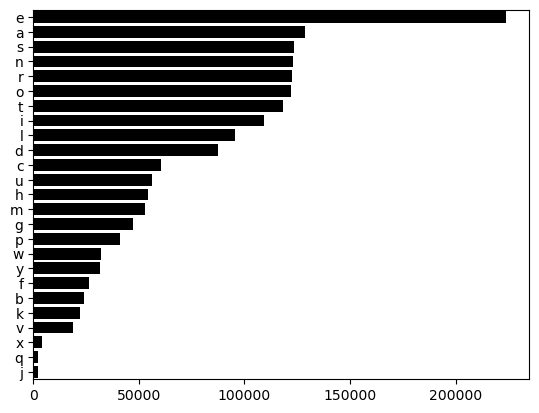

In [48]:
words, frequency = [], []
for word, count in most_common:
    words.append(word)
    frequency.append(count)
    
sns.barplot(x = frequency, y = words, color='black')

The extraction of the most common words across the stories of Sherlock Holmes do not provide too much of a surprise at a first glance: The frequent mentioning of the two protagonists names (Holmes and Watson) are to be expected. Furthermore the frequent usage of basic verbs might already suggest the establishing of a certain narrative tension throughout a given story. Last but not least high occurence of nouns such as 'room', 'door' or 'night' point towards more mysterious semantics, which can be attributed to the genre conventions of crime/detective fiction.

In [49]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df_sherlock['text_prepro'])
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

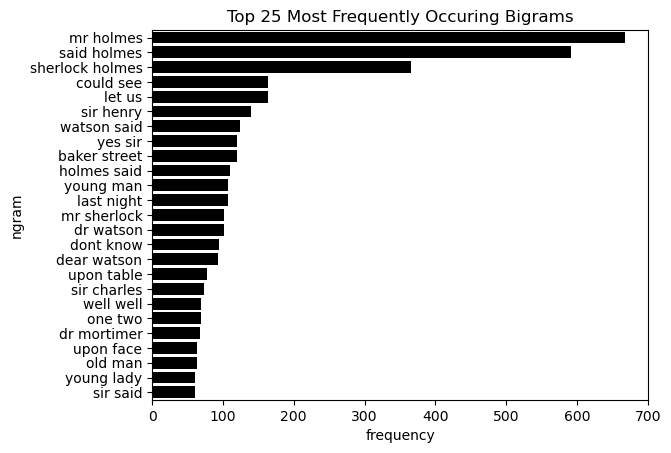

In [50]:
sns.barplot(x=ngram_freq['frequency'][:25], y=ngram_freq['ngram'][:25], color='black')
plt.title('Top 25 Most Frequently Occuring Bigrams')
plt.show()

In [51]:
cv2 = CountVectorizer(ngram_range=(3,3))
trigrams = cv2.fit_transform(df_sherlock['text_prepro'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv2.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

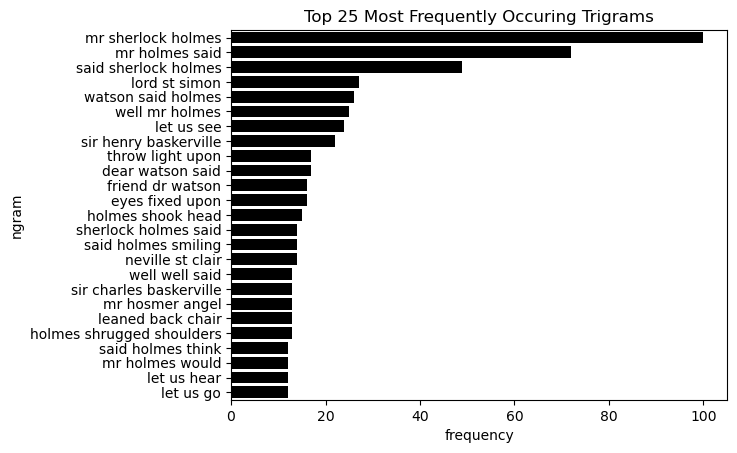

In [52]:
sns.barplot(x=ngram_freq['frequency'][:25], y=ngram_freq['ngram'][:25], color='black')
plt.title('Top 25 Most Frequently Occuring Trigrams')
plt.show()

<h2>Feature Engineering</h2>

<h3> Narrative coherence </h3>

In [116]:
keywords_dict = pd.read_csv('./data/AON Dict - Without Overlaps.dic', sep='\t')

keywords_dict.reset_index(inplace=True)

keywords_dict = keywords_dict.iloc[4:]

keywords_dict['index'] = keywords_dict['index'].str.replace('*', '')

In [117]:
df_staging = keywords_dict.loc[keywords_dict['%'] == '1']
staging = df_staging['index'].tolist()

df_plot_progress = keywords_dict.loc[keywords_dict['%'] == '2']
plot_progress = df_plot_progress['index'].tolist()

df_cognitive_tension = keywords_dict.loc[keywords_dict['%'] == '3']
cognitive_tension = df_cognitive_tension['index'].tolist()

In [118]:
def count_matches(tokens, word_list):
    count = sum([1 for token in tokens if token in word_list])
    return count

df_sherlock_segments_narrative['staging_count'] = df_sherlock_segments_narrative.apply(lambda row: count_matches(row['segments_narrative'], staging), axis=1)

df_sherlock_segments_narrative['plot_progress_count'] = df_sherlock_segments_narrative.apply(lambda row: count_matches(row['segments_narrative'], plot_progress), axis=1)

df_sherlock_segments_narrative['cognitive_tension_count'] = df_sherlock_segments_narrative.apply(lambda row: count_matches(row['segments_narrative'], cognitive_tension), axis=1)

In [28]:
def min_max_scale_column(df, new_column_name, col_to_norm, col_length):
    df['tf'] = df[col_to_norm] / len(df[col_length])
    df['idf'] = math.log(60) / (df[col_to_norm] != 0).value_counts()[True]
    df[new_column_name] = df['tf'] * df['idf']
    scaler = MinMaxScaler()
    df[new_column_name] = scaler.fit_transform(df[[new_column_name]])
    return df

In [120]:
df_sherlock_segments_narrative = min_max_scale_column(df_sherlock_segments_narrative, 'staging_count_norm', 'staging_count', 'text_prepro_tok_narrative')

df_sherlock_segments_narrative = min_max_scale_column(df_sherlock_segments_narrative, 'plot_progress_count_norm', 'plot_progress_count', 'text_prepro_tok_narrative')

df_sherlock_segments_narrative = min_max_scale_column(df_sherlock_segments_narrative, 'cognitive_tension_count_norm', 'cognitive_tension_count', 'text_prepro_tok_narrative')

In [121]:
summary_stats_narrative = df_sherlock_segments_narrative[['segment_num', 'staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm']].groupby('segment_num').agg(['mean', 'std'])

<Axes: xlabel='segment_num', ylabel="('staging_count_norm', 'mean')">

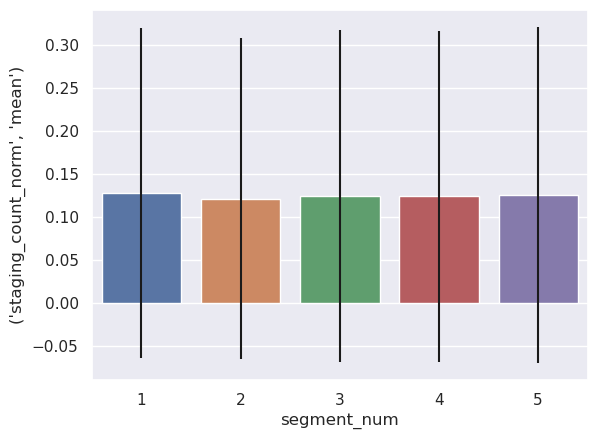

In [122]:
sns.barplot(x=summary_stats_narrative.index, y=summary_stats_narrative[('staging_count_norm', 'mean')], 
            yerr=summary_stats_narrative[('staging_count_norm', 'std')])

<Axes: xlabel='segment_num', ylabel="('plot_progress_count_norm', 'mean')">

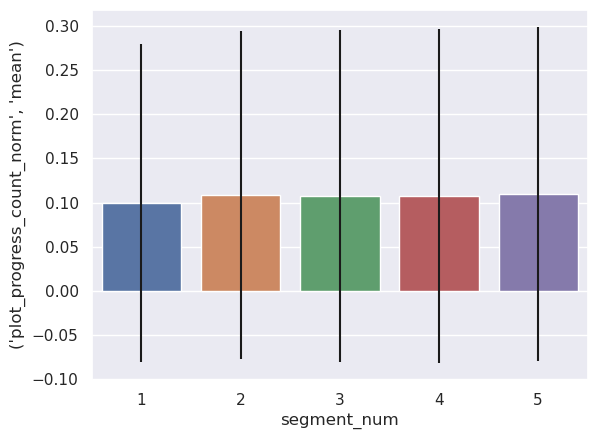

In [123]:
sns.barplot(x=summary_stats_narrative.index, y=summary_stats_narrative[('plot_progress_count_norm', 'mean')], 
            yerr=summary_stats_narrative[('plot_progress_count_norm', 'std')])

<Axes: xlabel='segment_num', ylabel="('cognitive_tension_count_norm', 'mean')">

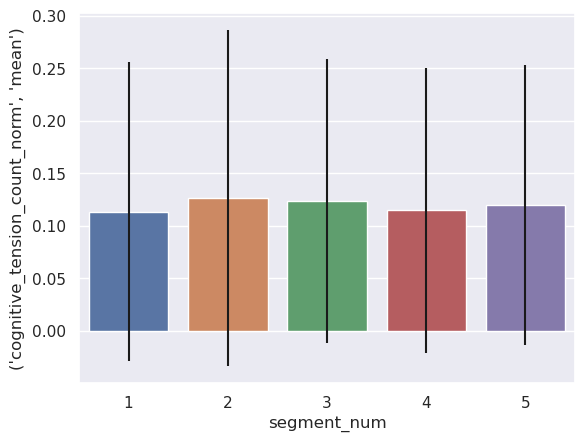

In [124]:
sns.barplot(x=summary_stats_narrative.index, y=summary_stats_narrative[('cognitive_tension_count_norm', 'mean')], 
            yerr=summary_stats_narrative[('cognitive_tension_count_norm', 'std')])

<Axes: xlabel='segment_num', ylabel='value'>

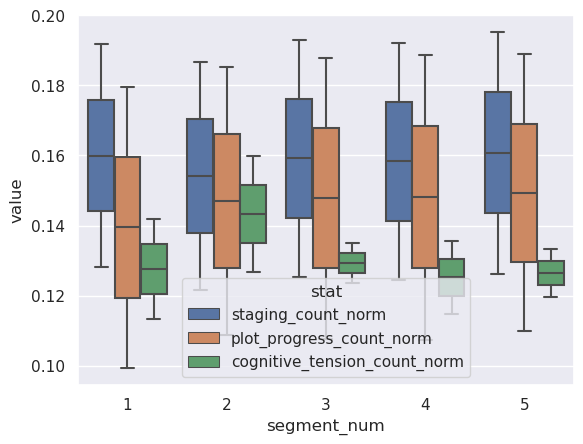

In [125]:
summary_stats_narrative = summary_stats_narrative.reset_index()
summary_stats_narrative = pd.melt(summary_stats_narrative, id_vars=['segment_num'], var_name='stat', value_name='value')
summary_stats_narrative = summary_stats_narrative.drop(index=summary_stats_narrative[(summary_stats_narrative['stat'] == 'level_0') | summary_stats_narrative['stat'] =='index'].index)

sns.boxplot(data = summary_stats_narrative, x='segment_num', y='value', hue='stat')

In [39]:
def group_df(df, value):
    ls = []
    for i in range(1, df['segment_num'].nunique() + 1):
        ls.append(df[df['segment_num'] == i][value])
    return ls

In [127]:
ls_anova = group_df(df_sherlock_segments_narrative, 'staging_count_norm')

fvalue_staging, pvalue_staging = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for plot staging (fvalue, pvalue): {}, {}'.format(fvalue_staging, pvalue_staging))

Results for ANOVA test for plot staging (fvalue, pvalue): 0.009082105721400504, 0.9998359366838404


In [128]:
ls_anova = group_df(df_sherlock_segments_narrative, 'plot_progress_count_norm')

fvalue_progress, pvalue_progress = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for plot progression (fvalue, pvalue): {}, {}'.format(fvalue_progress, pvalue_progress))

Results for ANOVA test for plot progression (fvalue, pvalue): 0.030157002392953786, 0.9982417153229941


In [129]:
ls_anova = group_df(df_sherlock_segments_narrative, 'cognitive_tension_count_norm')

fvalue_cog, pvalue_cog = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for cognitive tension (fvalue, pvalue): {}, {}'.format(fvalue_cog, pvalue_cog))

Results for ANOVA test for cognitive tension (fvalue, pvalue): 0.09454006335117685, 0.9841444112445688


<Axes: xlabel='plot_element', ylabel='value'>

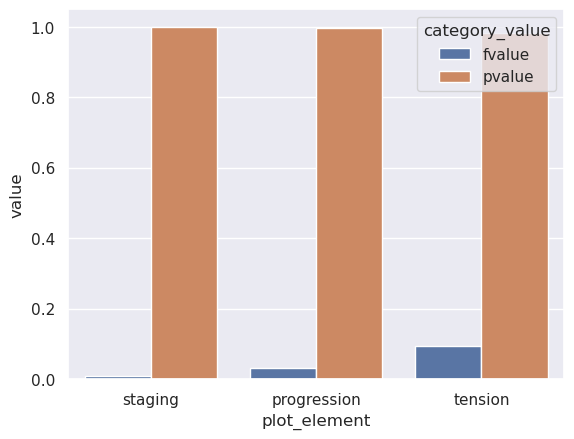

In [115]:
col1 = [fvalue_staging, fvalue_progress, fvalue_cog, pvalue_staging, pvalue_progress, pvalue_cog]
col2 = ['staging', 'progression', 'tension', 'staging', 'progression', 'tension']
col3 = ['fvalue', 'fvalue', 'fvalue', 'pvalue', 'pvalue', 'pvalue']

df_dict = {'value': col1, 'plot_element': col2, 'category_value': col3}

df_anova_narrative = pd.DataFrame(df_dict)

sns.barplot(data = df_anova_narrative, x='plot_element', y ='value', hue = 'category_value')

In [90]:
df_sherlock_segments_narrative_vec = df_sherlock_segments_narrative[['title', 'staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm']]

df_sherlock_segments_narrative_vec = df_sherlock_segments_narrative_vec.groupby('title').agg(lambda x: x.tolist())

df_sherlock_segments_narrative_vec['vector'] = df_sherlock_segments_narrative_vec.apply(lambda row: [val for sublist in row.values for val in sublist], axis=1)
df_sherlock_segments_narrative_vec.reset_index(inplace=True)
df_sherlock_segments_narrative_vec = df_sherlock_segments_narrative_vec[['title', 'vector']]

In [91]:
matrix_vec = np.array(df_sherlock_segments_narrative_vec['vector'].tolist())

similarity_matrix = cosine_similarity(matrix_vec)

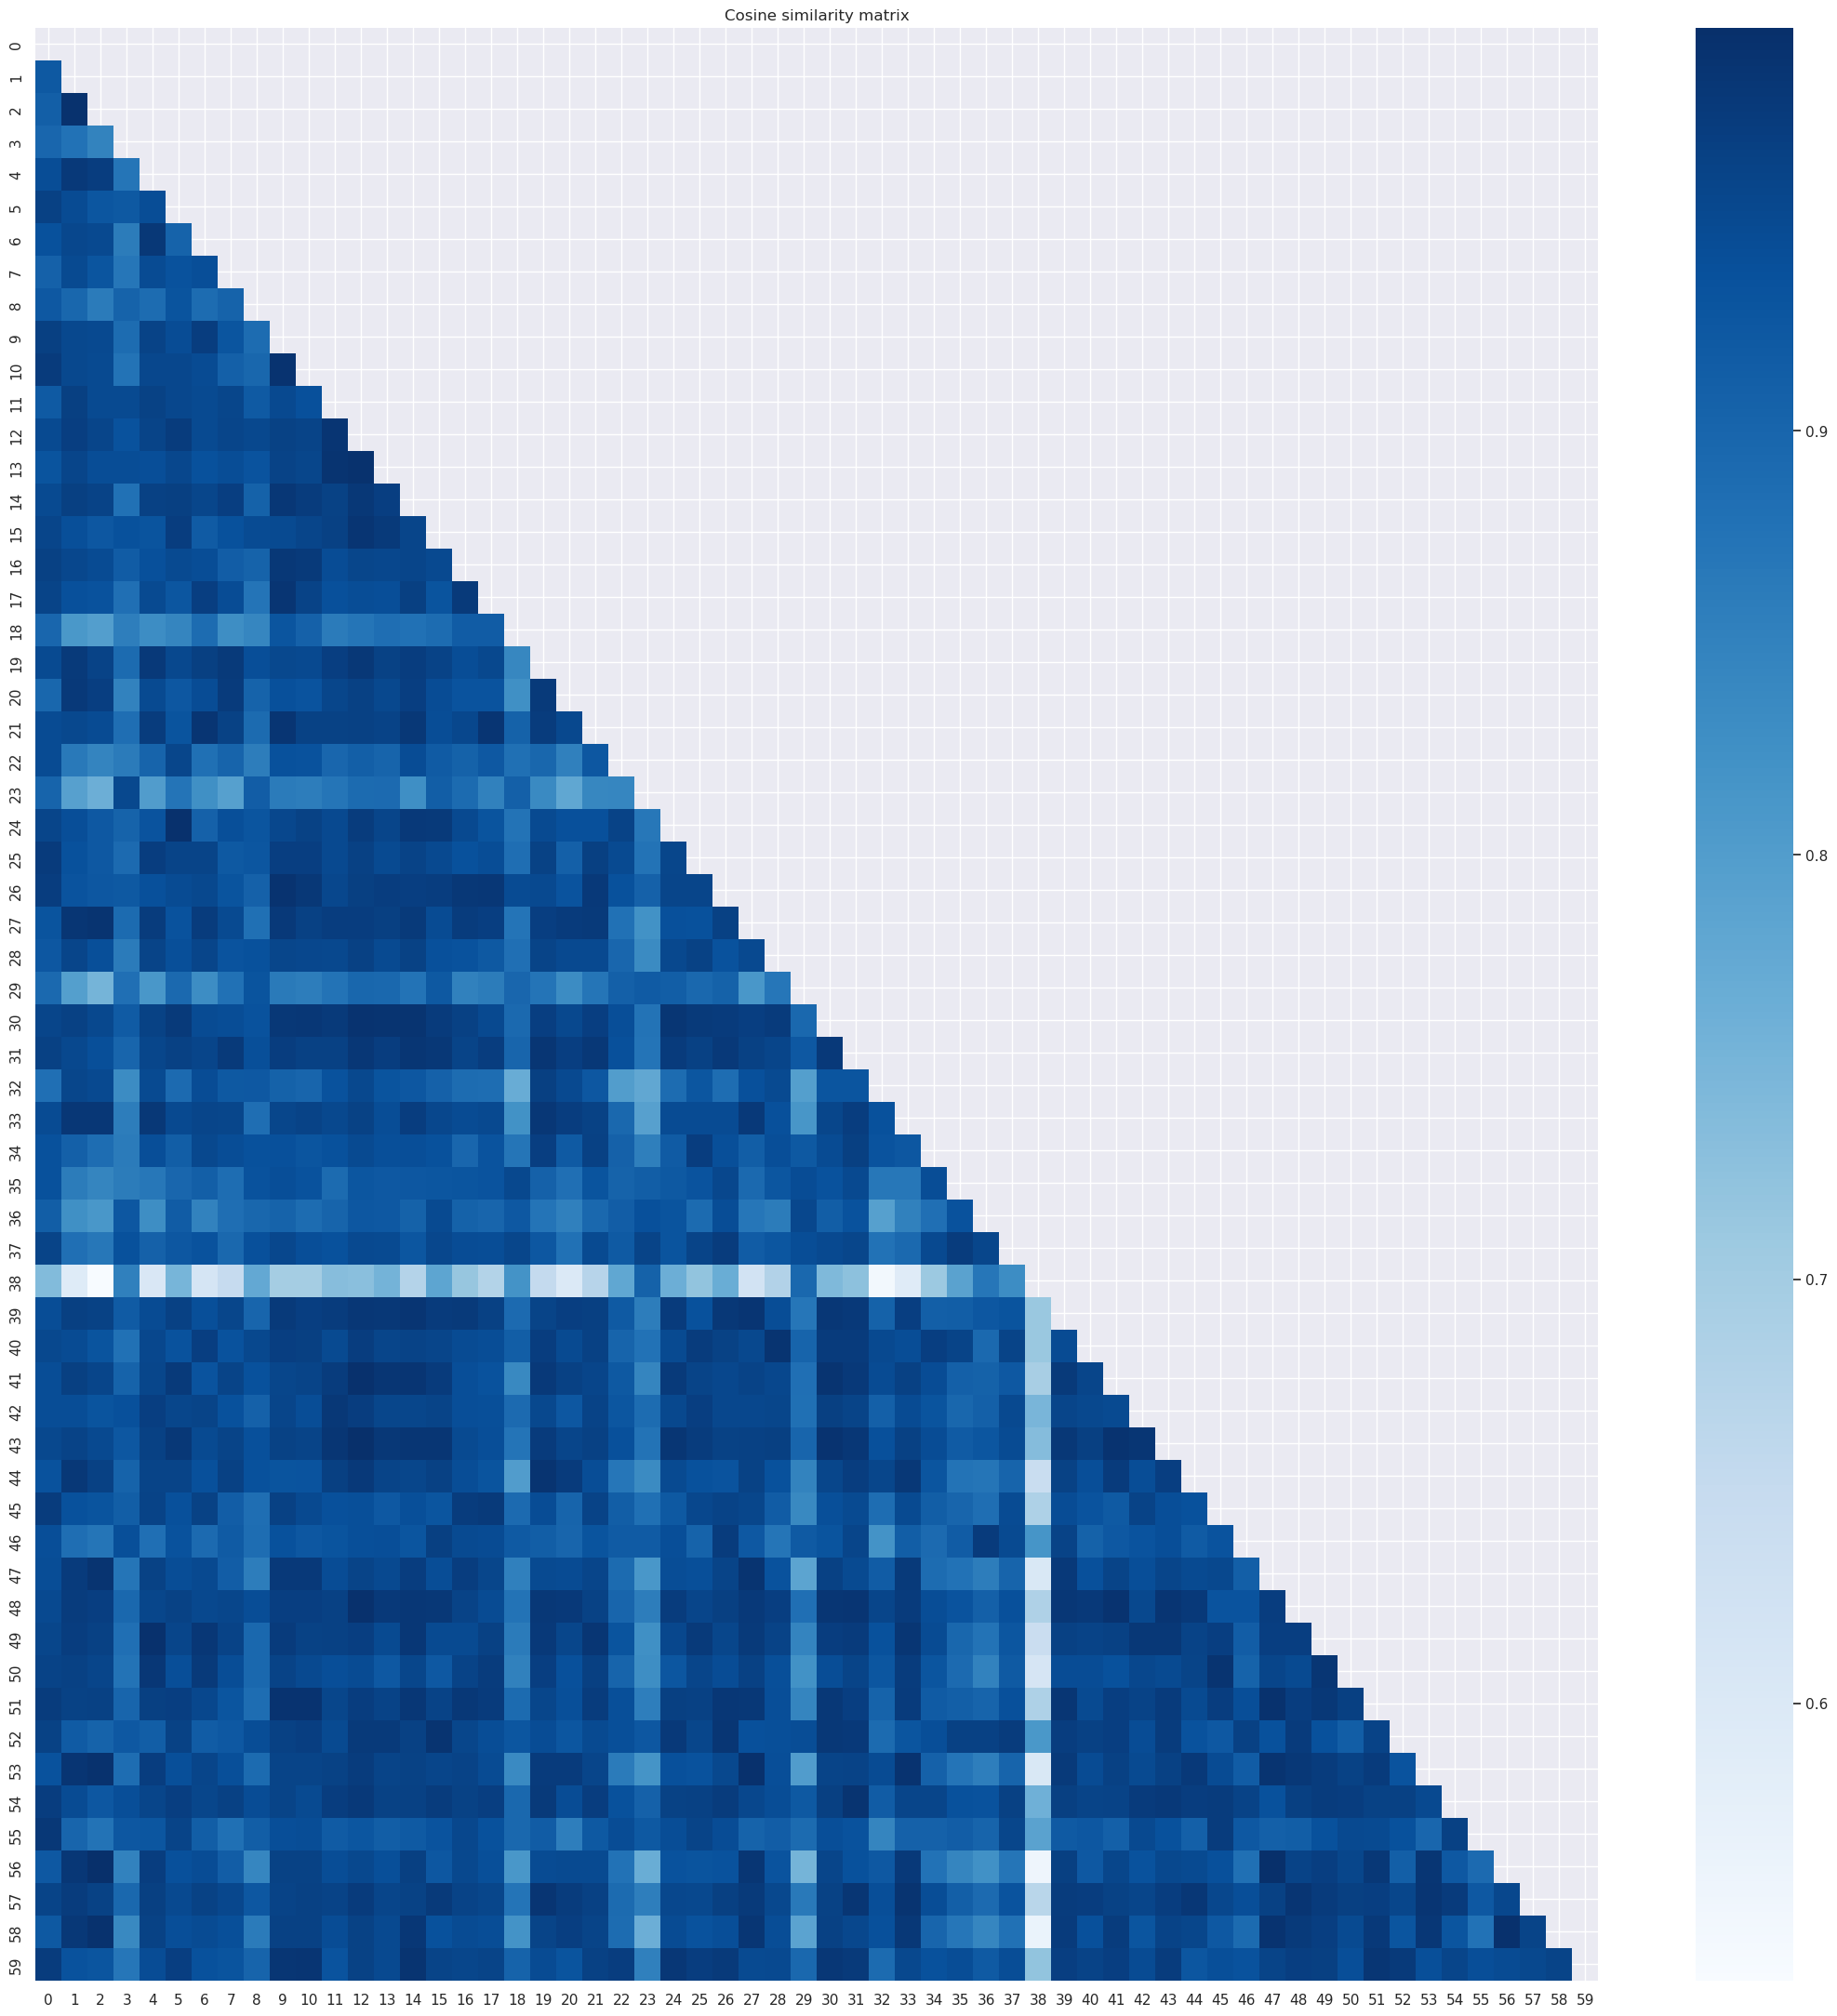

In [92]:
mask = np.triu(np.ones_like(similarity_matrix, dtype=bool))

sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(similarity_matrix, annot=False, cmap='Blues', mask=mask, ax=ax)
plt.subplots_adjust(left=0.25, bottom=0.25, right=0.95, top=0.95)
plt.title('Cosine similarity matrix')
plt.show()

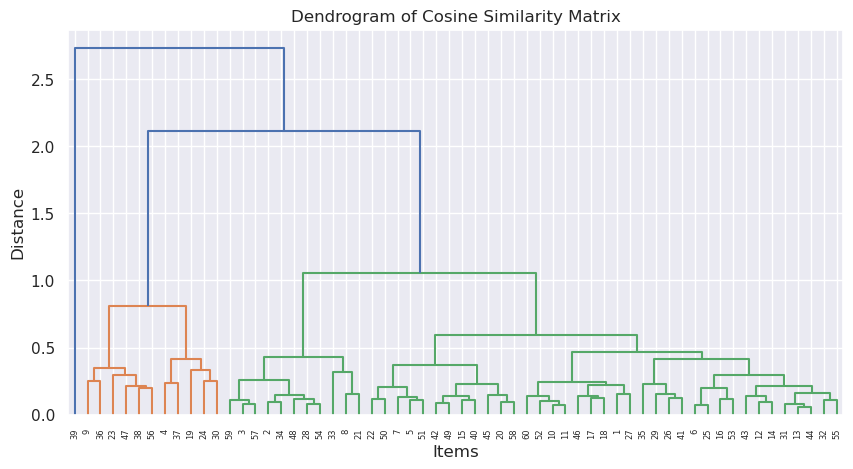

In [93]:
linkage_matrix = linkage(similarity_matrix, method='ward')

fig, ax = plt.subplots(figsize=(10, 5))
dendrogram(linkage_matrix, labels=range(1,61))
plt.title('Dendrogram of Cosine Similarity Matrix')
plt.xlabel('Items')
plt.ylabel('Distance')
plt.show()

In [94]:
cluster_assignments = fcluster(linkage_matrix, t=3, criterion = 'maxclust')

df_sherlock_segments_narrative_vec['cluster'] = cluster_assignments

In [95]:
df_sherlock_segments_narrative = pd.merge(df_sherlock_segments_narrative, df_sherlock_segments_narrative_vec[['title', 'cluster']], on='title', how='left')

In [96]:
df_sherlock_pivot = df_sherlock_segments_narrative[['title', 'segment_num', 'staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm', 'cluster']]

df_sherlock_pivot = pd.melt(df_sherlock_pivot, id_vars=['segment_num','title', 'cluster'], var_name='var', value_name= 'val')

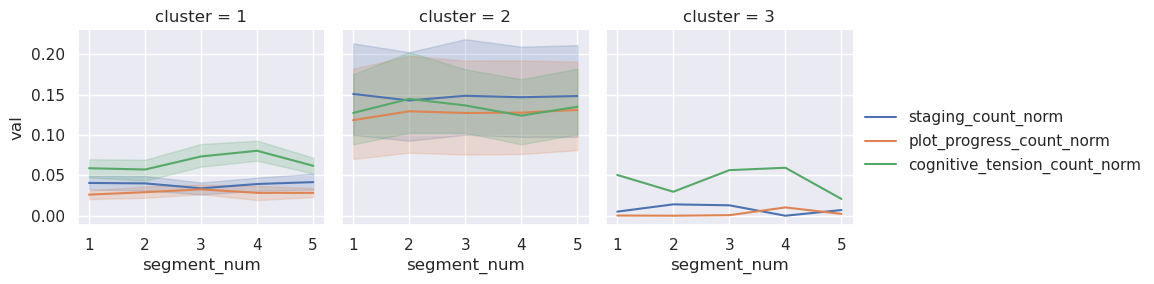

In [97]:
fg = sns.FacetGrid(df_sherlock_pivot, col='cluster')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='var')

fg.add_legend()

In [98]:
df_sherlock_pivot_cluster1 = df_sherlock_pivot.loc[df_sherlock_pivot['cluster'] == 1]

df_sherlock_pivot_cluster2 = df_sherlock_pivot.loc[df_sherlock_pivot['cluster'] == 2]

df_sherlock_pivot_cluster3 = df_sherlock_pivot.loc[df_sherlock_pivot['cluster']== 3]

In [ ]:
fg = sns.FacetGrid(df_sherlock_pivot_cluster1, row='title')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='var')

fg.set(xticks = range(1, 6, 1))

fg.add_legend(bbox_to_anchor = (1.05, 0.5), loc='center left')

In [ ]:
fg = sns.FacetGrid(df_sherlock_pivot_cluster2, row='title')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='var')

fg.set(xticks = range(1, 6, 1))

fg.add_legend(bbox_to_anchor = (1.05, 0.5), loc='center left')

In [ ]:
fg = sns.FacetGrid(df_sherlock_pivot_cluster3, row='title')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='var')

fg.set(xticks = range(1, 6, 1))

fg.add_legend(bbox_to_anchor = (1.05, 0.5), loc='center left')

<h3> Temporal usage </h3>

In [31]:
def pos_tag_text(text):
    pos_tags = nltk.pos_tag(text)
    return pos_tags

df_sherlock_segments_temp['text_pos'] = df_sherlock_segments_temp['segments_temp'].apply(pos_tag_text)

In [26]:
def tense_counts(pos_tags):
    past_count = 0
    present_count = 0
    future_count = 0
    
    for word, tag in pos_tags[1::2]:
        if tag.startswith('VBD'):
            past_count += 1
        elif tag.startswith('VB'):
            present_count += 1
        elif tag.startswith('MD'):
            future_count += 1
    
    counts = {'past_count': past_count,
              'present_count': present_count,
              'future_count': future_count}
    
    return pd.Series(counts)        
    
    
df_sherlock_segments_temp[['past_count', 'present_count', 'future_count']] = df_sherlock_segments_temp['text_pos'].apply(tense_counts)

In [27]:
df_sherlock_segments_temp = min_max_scale_column(df_sherlock_segments_temp, 'future_count_norm', 'future_count', 'text_prepro_tok')

df_sherlock_segments_temp = min_max_scale_column(df_sherlock_segments_temp, 'past_count_norm', 'past_count', 'text_prepro_tok')

df_sherlock_segments_temp = min_max_scale_column(df_sherlock_segments_temp, 'present_count_norm', 'present_count', 'text_prepro_tok')

In [28]:
df_sherlock_pivot = df_sherlock_segments_temp[['title', 'segment_num', 'future_count_norm', 'past_count_norm', 'present_count_norm']]

df_sherlock_pivot = pd.melt(df_sherlock_pivot, id_vars=['segment_num','title'], var_name='var', value_name= 'val')

In [ ]:
fg = sns.FacetGrid(df_sherlock_pivot, row='title')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='var')

In [30]:
summary_stats_tenses = df_sherlock_segments_temp[['segment_num', 'present_count_norm', 'future_count_norm', 'past_count_norm']].groupby('segment_num').agg(['mean', 'std'])

<Axes: xlabel='segment_num', ylabel="('present_count_norm', 'mean')">

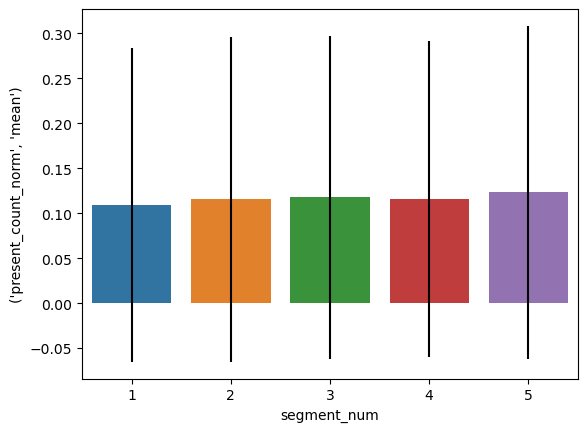

In [31]:
sns.barplot(x=summary_stats_tenses.index, y=summary_stats_tenses[('present_count_norm', 'mean')], 
            yerr=summary_stats_tenses[('present_count_norm', 'std')])

<Axes: xlabel='segment_num', ylabel="('past_count_norm', 'mean')">

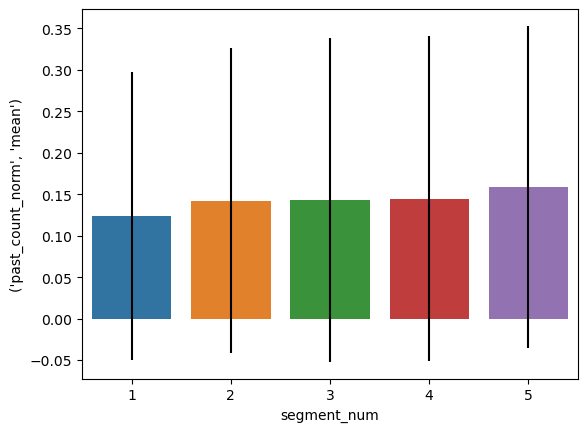

In [32]:
sns.barplot(x=summary_stats_tenses.index, y=summary_stats_tenses[('past_count_norm', 'mean')], 
            yerr=summary_stats_tenses[('past_count_norm', 'std')])

<Axes: xlabel='segment_num', ylabel="('future_count_norm', 'mean')">

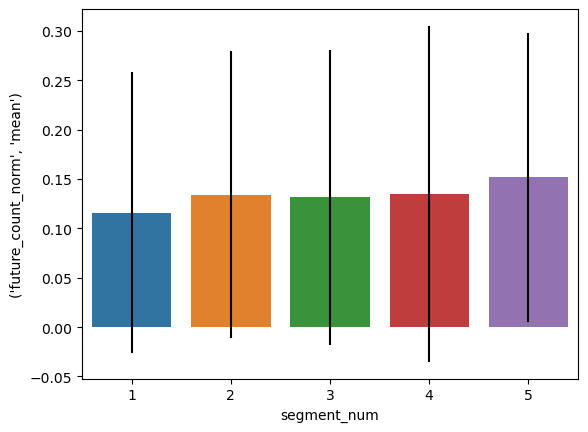

In [33]:
sns.barplot(x=summary_stats_tenses.index, y=summary_stats_tenses[('future_count_norm', 'mean')], 
            yerr=summary_stats_tenses[('future_count_norm', 'std')])

<Axes: xlabel='segment_num', ylabel='value'>

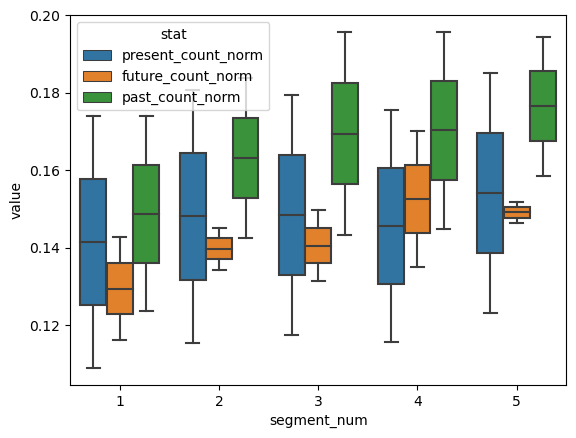

In [34]:
summary_stats_tenses = summary_stats_tenses.reset_index()
summary_stats_tenses = pd.melt(summary_stats_tenses, id_vars=['segment_num'], var_name='stat', value_name='value')
summary_stats_tenses = summary_stats_tenses.drop(index=summary_stats_tenses[(summary_stats_tenses['stat'] == 'level_0') | summary_stats_tenses['stat'] =='index'].index)

sns.boxplot(data = summary_stats_tenses, x='segment_num', y='value', hue='stat')

In [179]:
ls_anova = group_df(df_sherlock_segments_temp, 'past_count_norm')

fvalue_past, pvalue_past = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for past tense usage (fvalue, pvalue): {}, {}'.format(fvalue_past, pvalue_past))

Results for ANOVA test for past tense usage (fvalue, pvalue): 0.2624311499079588, 0.9019034746678652


In [180]:
ls_anova = group_df(df_sherlock_segments_temp, 'present_count_norm')

fvalue_present, pvalue_present = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for present tense usage (fvalue, pvalue): {}, {}'.format(fvalue_present, pvalue_present))

Results for ANOVA test for present tense usage (fvalue, pvalue): 0.047365059057391835, 0.9957616207509549


In [181]:
ls_anova = group_df(df_sherlock_segments_temp, 'future_count_norm')

fvalue_future, pvalue_future = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for future tense usage (fvalue, pvalue): {}, {}'.format(fvalue_future, pvalue_future))

Results for ANOVA test for future tense usage (fvalue, pvalue): 0.42324687854693605, 0.7918329886020543


<Axes: xlabel='tense', ylabel='value'>

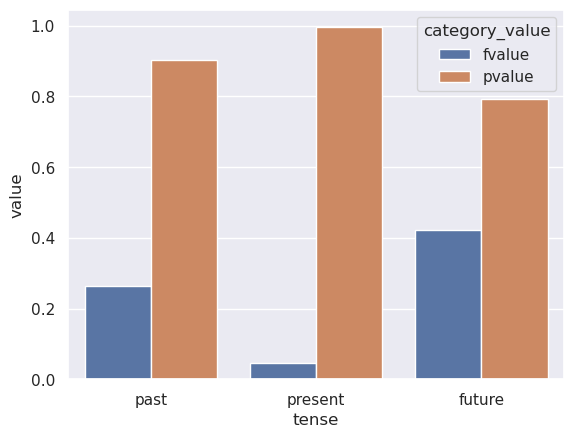

In [182]:
col1 = [fvalue_past, fvalue_present, fvalue_future, pvalue_past, pvalue_present, pvalue_future]
col2 = ['past', 'present', 'future', 'past', 'present', 'future']
col3 = ['fvalue', 'fvalue', 'fvalue', 'pvalue', 'pvalue', 'pvalue']

df_dict = {'value': col1, 'tense': col2, 'category_value': col3}

df_anova_tenses = pd.DataFrame(df_dict)

sns.barplot(data = df_anova_tenses, x='tense', y ='value', hue = 'category_value')

In [183]:
df_sherlock_segments_temp_vec = df_sherlock_segments_temp[['title', 'present_count_norm', 'past_count_norm', 'future_count_norm']]

df_sherlock_segments_temp_vec = df_sherlock_segments_temp_vec.groupby('title').agg(lambda x: x.tolist())

df_sherlock_segments_temp_vec['vector'] = df_sherlock_segments_temp_vec.apply(lambda row: [val for sublist in row.values for val in sublist], axis=1)
df_sherlock_segments_temp_vec.reset_index(inplace=True)
df_sherlock_segments_temp_vec = df_sherlock_segments_temp_vec[['title', 'vector']]  
matrix_vec = np.array(df_sherlock_segments_temp_vec['vector'].tolist())

similarity_matrix = cosine_similarity(matrix_vec)


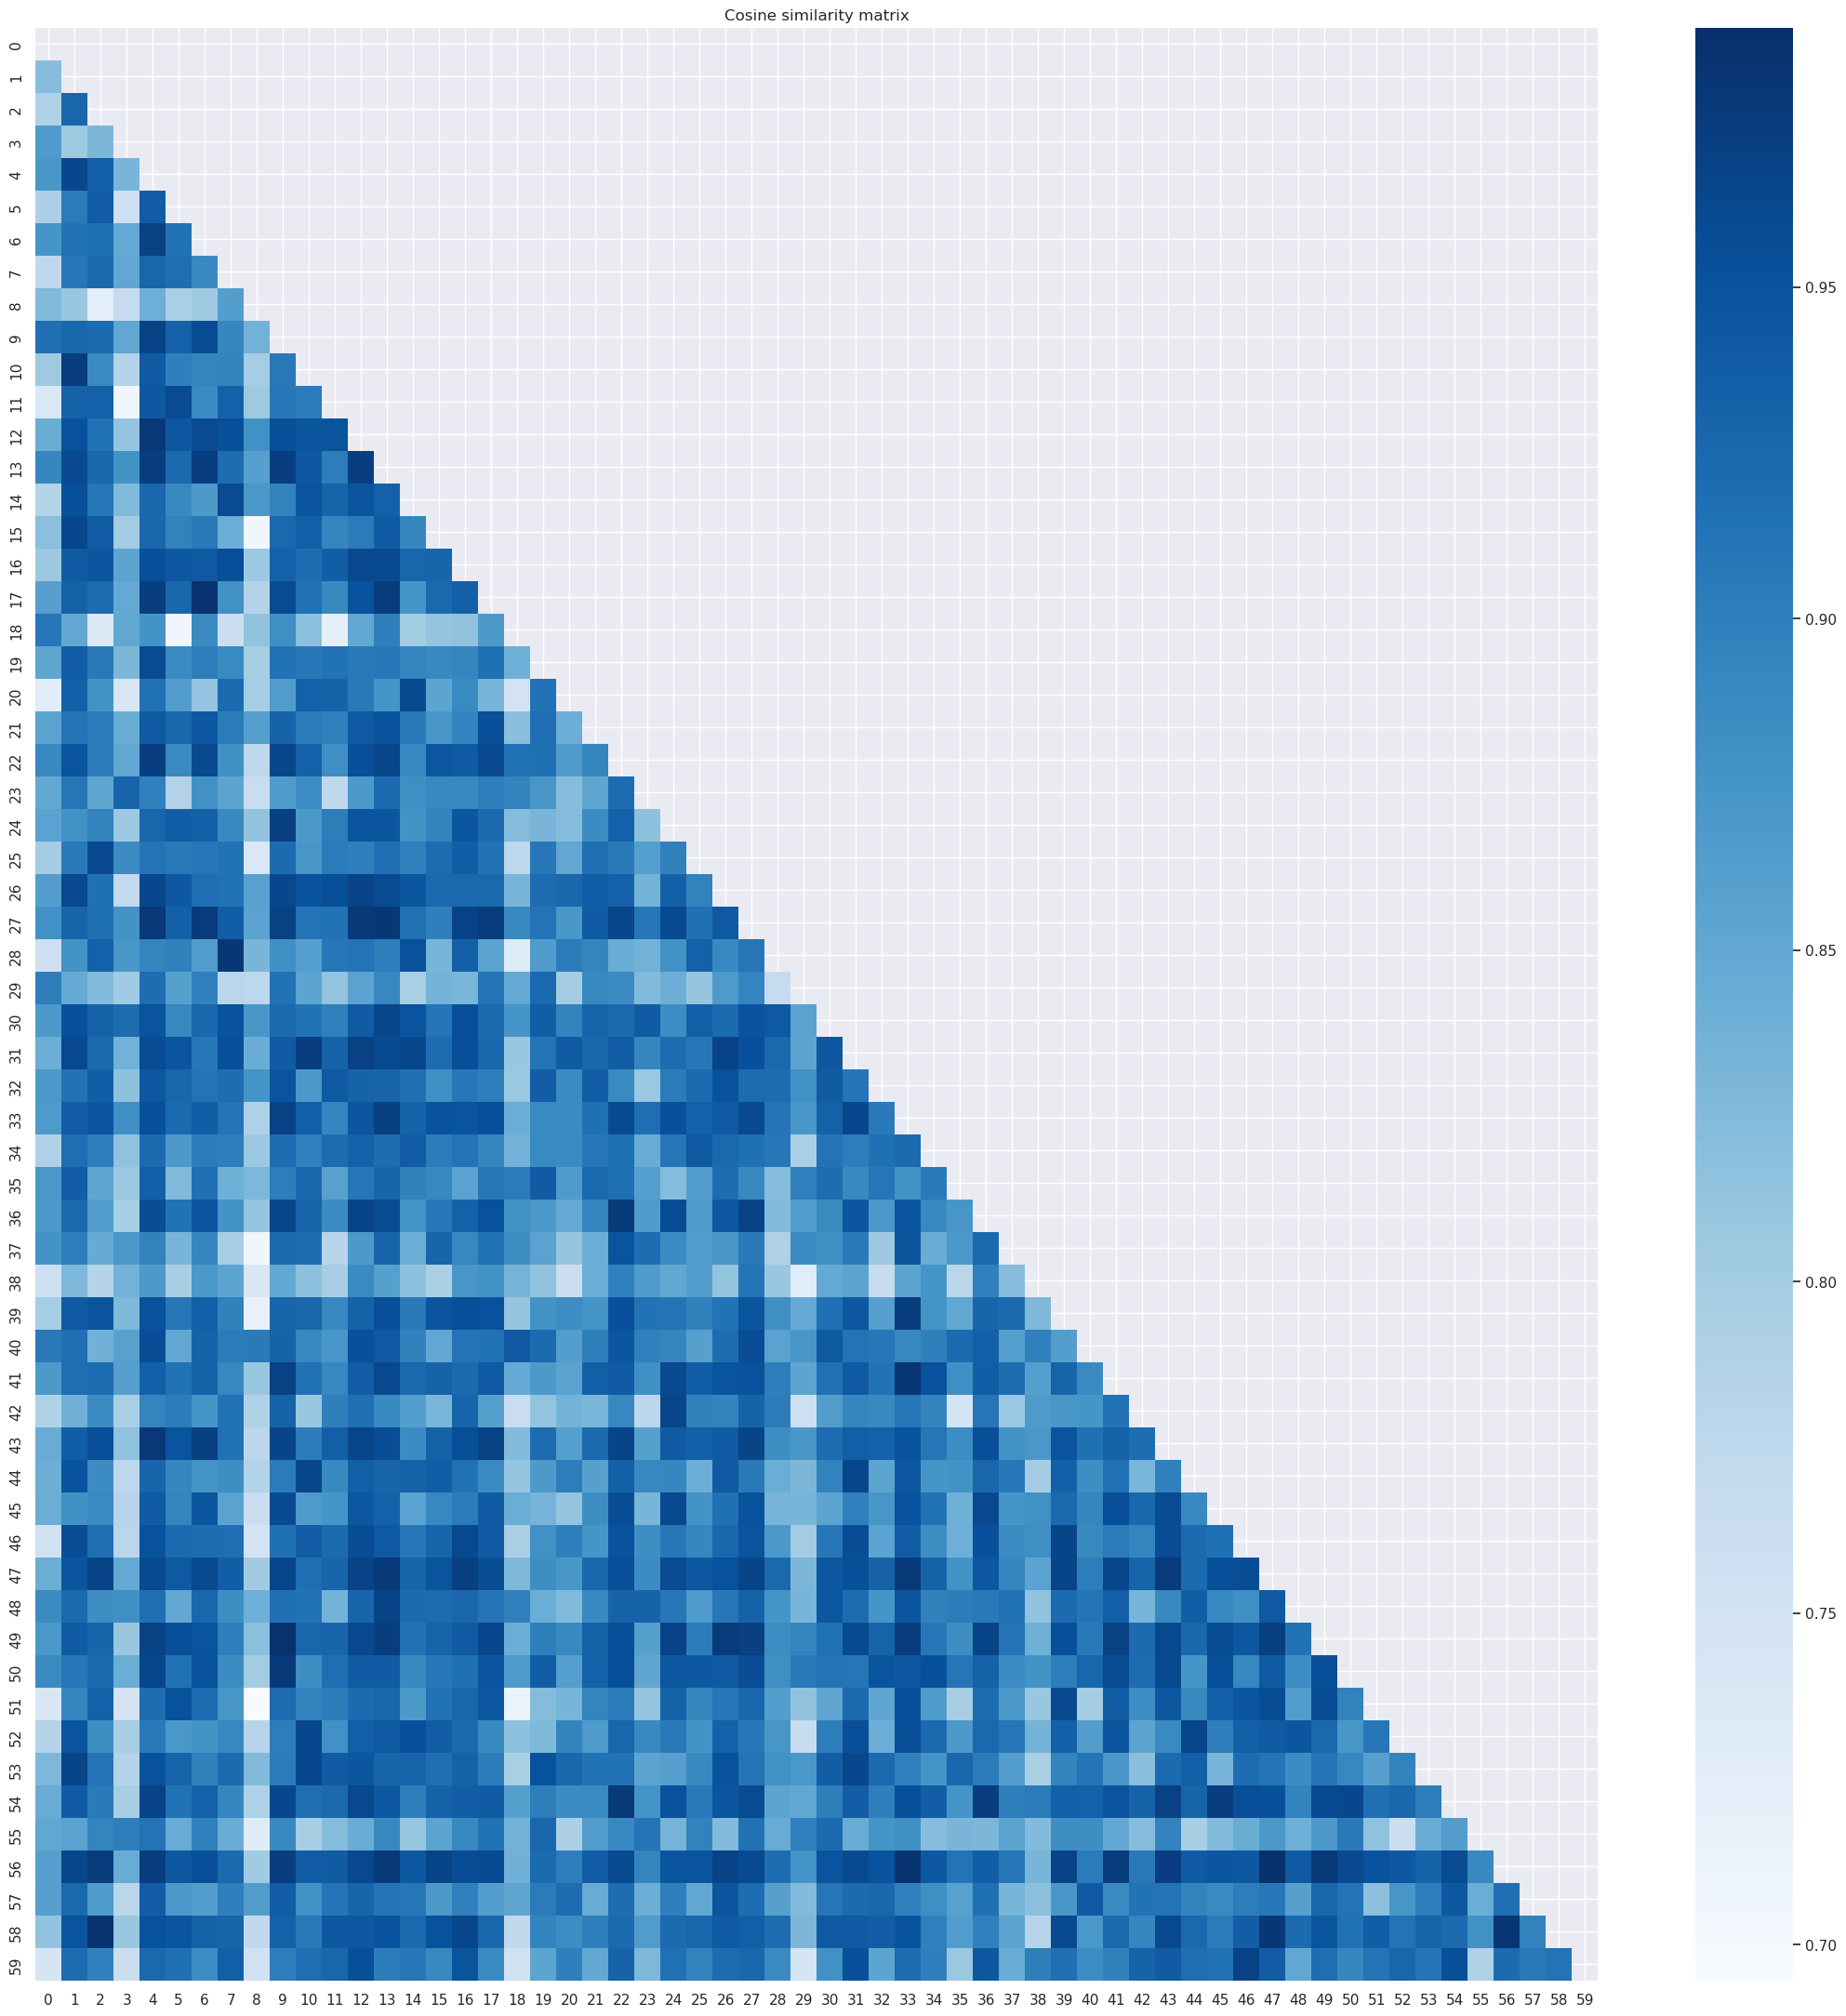

In [184]:
mask = np.triu(np.ones_like(similarity_matrix, dtype=bool))

sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(similarity_matrix, annot=False, cmap='Blues', mask=mask, ax=ax)
plt.subplots_adjust(left=0.25, bottom=0.25, right=0.95, top=0.95)
plt.title('Cosine similarity matrix')
plt.show()

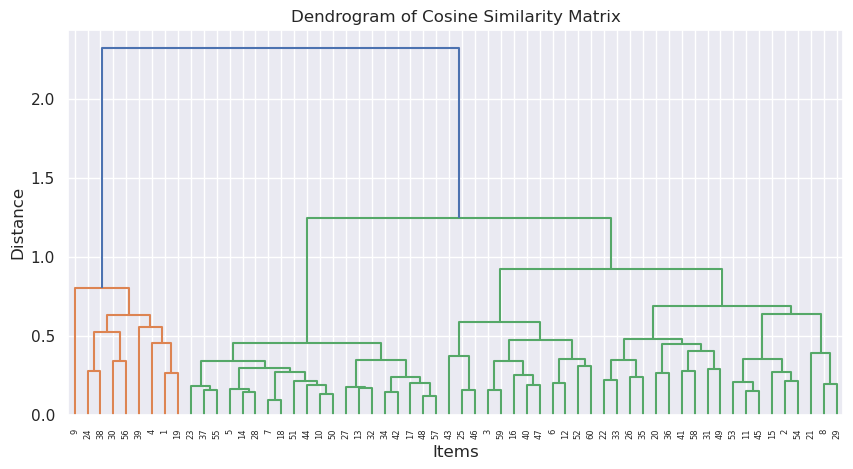

In [185]:
linkage_matrix = linkage(similarity_matrix, method='ward')

fig, ax = plt.subplots(figsize=(10, 5))
dendrogram(linkage_matrix, labels=range(1,61))
plt.title('Dendrogram of Cosine Similarity Matrix')
plt.xlabel('Items')
plt.ylabel('Distance')
plt.show()

In [186]:
cluster_assignments = fcluster(linkage_matrix, t=2, criterion = 'maxclust')

df_sherlock_segments_temp_vec['cluster'] = cluster_assignments
df_sherlock_segments_temp = pd.merge(df_sherlock_segments_temp, df_sherlock_segments_temp_vec[['title', 'cluster']], on='title', how='left')
df_sherlock_pivot = df_sherlock_segments_temp[['title', 'segment_num', 'past_count_norm', 'present_count_norm', 'future_count_norm', 'cluster']]

df_sherlock_pivot = pd.melt(df_sherlock_pivot, id_vars=['segment_num','title', 'cluster'], var_name='var', value_name= 'val')


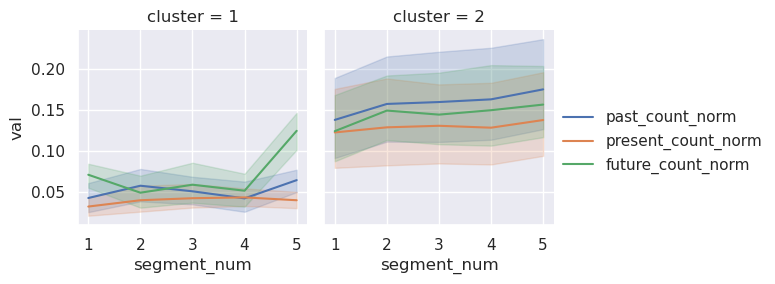

In [187]:
fg = sns.FacetGrid(df_sherlock_pivot, col='cluster')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='var')

fg.add_legend()

In [ ]:
df_sherlock_pivot_cluster1 = df_sherlock_pivot.loc[df_sherlock_pivot['cluster'] == 1]

df_sherlock_pivot_cluster2 = df_sherlock_pivot.loc[df_sherlock_pivot['cluster'] == 2]

df_sherlock_pivot_cluster3 = df_sherlock_pivot.loc[df_sherlock_pivot['cluster']== 3]

In [ ]:
fg = sns.FacetGrid(df_sherlock_pivot_cluster1, row='title')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='var')

fg.set(xticks = range(1, 6, 1))

fg.add_legend(bbox_to_anchor = (1.05, 0.5), loc='center left')

In [ ]:
fg = sns.FacetGrid(df_sherlock_pivot_cluster2, row='title')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='var')

fg.set(xticks = range(1, 6, 1))

fg.add_legend(bbox_to_anchor = (1.05, 0.5), loc='center left')

In [ ]:
fg = sns.FacetGrid(df_sherlock_pivot_cluster3, row='title')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='var')

fg.set(xticks = range(1, 6, 1))

fg.add_legend(bbox_to_anchor = (1.05, 0.5), loc='center left')

<h3> Emotion Analysis </h3>

In [35]:
vader = SentimentIntensityAnalyzer()

In [36]:
def get_sentiment_scores(sentence_list):
    scores = []
    for sentence in sentence_list:
        score = vader.polarity_scores(sentence)
        scores.append(score)
    return scores

df_sherlock_segments_vader['sentiment_score'] = df_sherlock_segments_vader['segments_vader'].apply(get_sentiment_scores)

get_avg_compound_score = lambda scores: sum([score['compound'] for score in scores])/len([score['compound'] for score in scores])
df_sherlock_segments_vader['avg_compound_score'] = df_sherlock_segments_vader['sentiment_score'].apply(get_avg_compound_score)

df_sherlock_segments_vader = df_sherlock_segments_vader.drop('sentiment_score', axis=1)

In [37]:
summary_stats_emotion = df_sherlock_segments_vader[['segment_num', 'avg_compound_score']].groupby('segment_num').agg(['mean', 'std'])

<Axes: xlabel='segment_num', ylabel="('avg_compound_score', 'mean')">

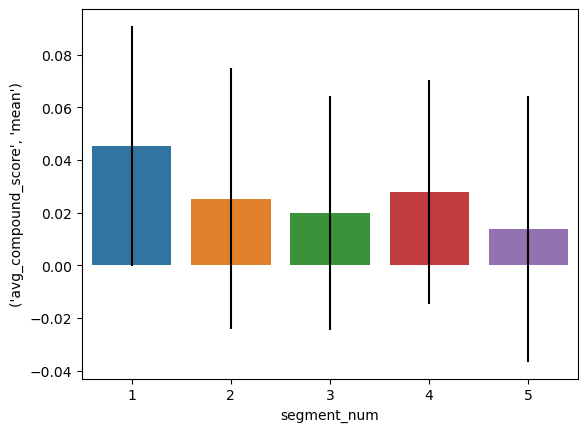

In [38]:
sns.barplot(x=summary_stats_emotion.index, y=summary_stats_emotion[('avg_compound_score', 'mean')], 
            yerr=summary_stats_emotion[('avg_compound_score', 'std')])

In [152]:
ls_anova = group_df(df_sherlock_segments_vader, 'avg_compound_score')

fvalue_emotion, pvalue_emotion = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for emotion analysis (fvalue, pvalue): {}, {}'.format(fvalue_emotion, pvalue_emotion))

Results for ANOVA test for emotion analysis (fvalue, pvalue): 3.8511919702664077, 0.00456500130063913


In [153]:
df_sherlock_pivot = df_sherlock_segments_vader[['title', 'segment_num', 'avg_compound_score']]

df_sherlock_pivot = pd.melt(df_sherlock_pivot, id_vars=['segment_num','title'], var_name='var', value_name= 'val')

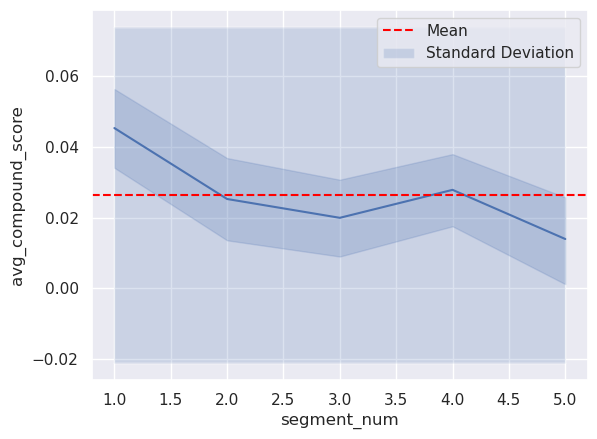

In [155]:
mean = df_sherlock_segments_vader['avg_compound_score'].mean()
std = df_sherlock_segments_vader['avg_compound_score'].std()

ax = sns.lineplot(x='segment_num', y='avg_compound_score', data=df_sherlock_segments_vader)
ax.axhline(mean, color='red', linestyle='--', label='Mean')
ax.fill_between(df_sherlock_segments_vader['segment_num'], mean-std, mean+std, alpha=0.2, label='Standard Deviation')
ax.legend()

In [162]:
df_sherlock_segments_vader_vec = df_sherlock_segments_vader[['title', 'avg_compound_score']]

df_sherlock_segments_vader_vec = df_sherlock_segments_vader_vec.groupby('title').agg(lambda x: x.tolist())

df_sherlock_segments_vader_vec.reset_index(inplace=True)

In [163]:
matrix_vec = np.array(df_sherlock_segments_vader_vec['avg_compound_score'].tolist())

similarity_matrix = cosine_similarity(matrix_vec)

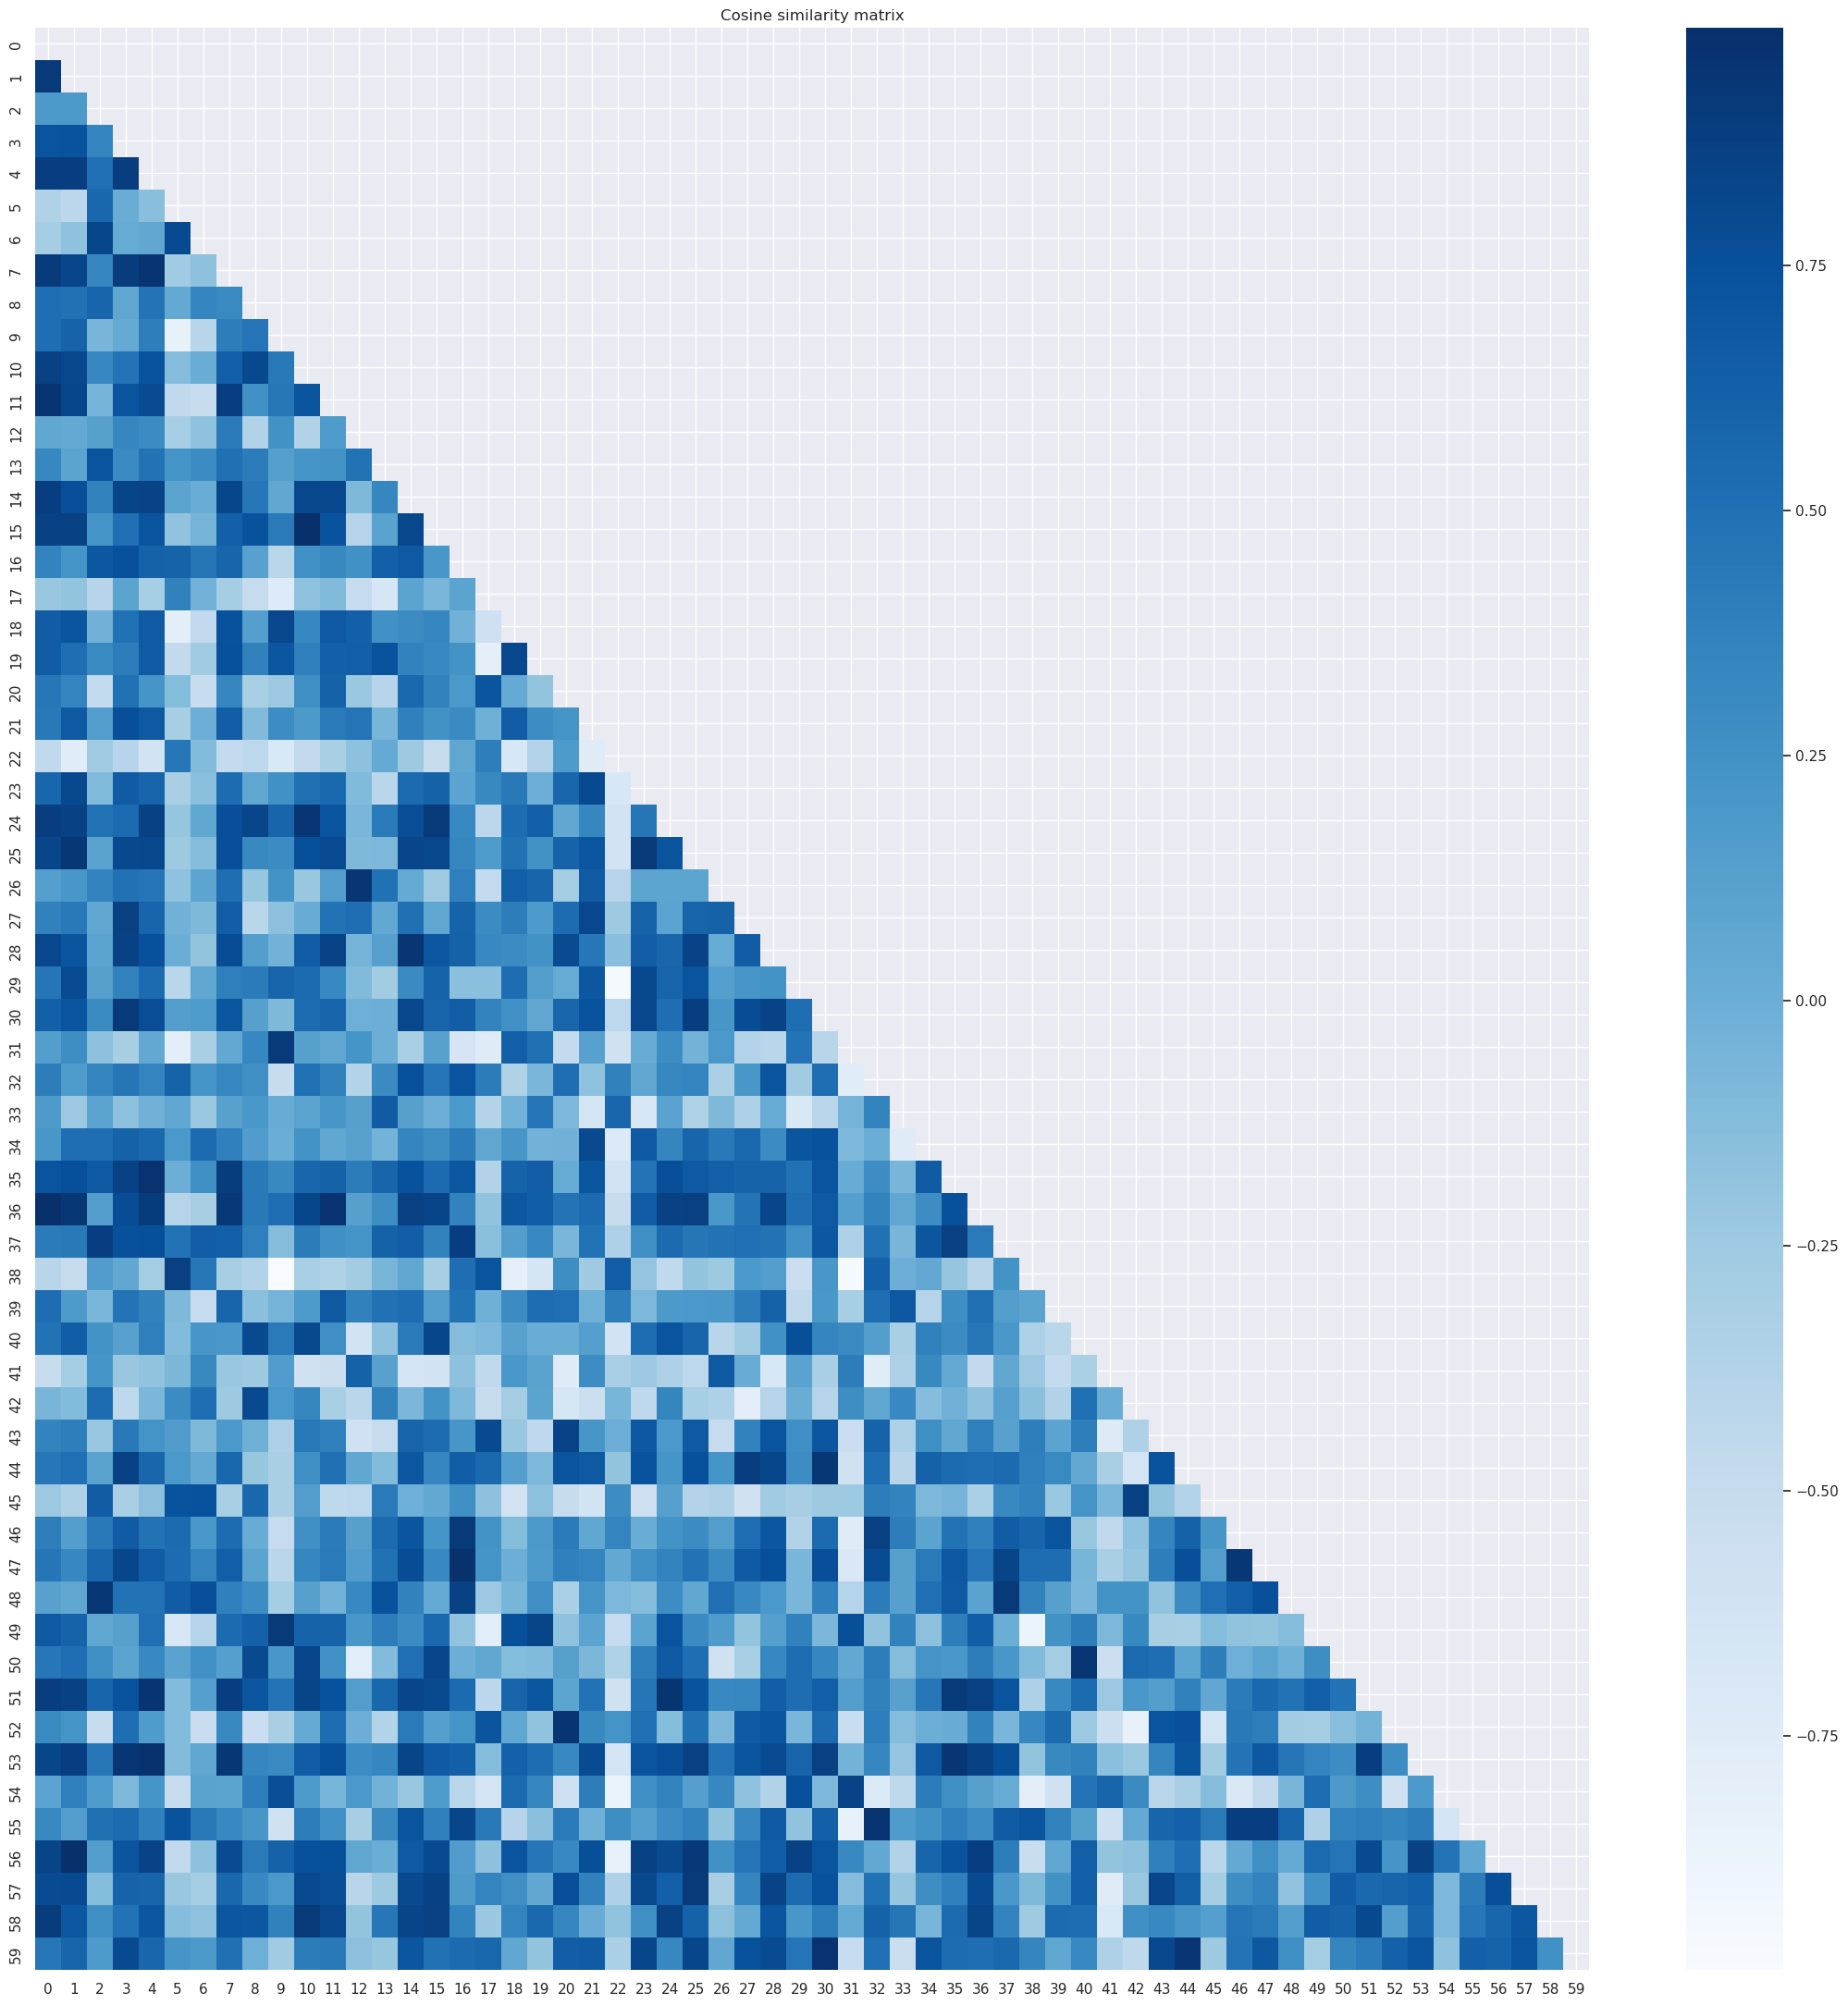

In [164]:
mask = np.triu(np.ones_like(similarity_matrix, dtype=bool))

sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(similarity_matrix, annot=False, cmap='Blues', mask=mask, ax=ax)
plt.subplots_adjust(left=0.25, bottom=0.25, right=0.95, top=0.95)
plt.title('Cosine similarity matrix')
plt.show()

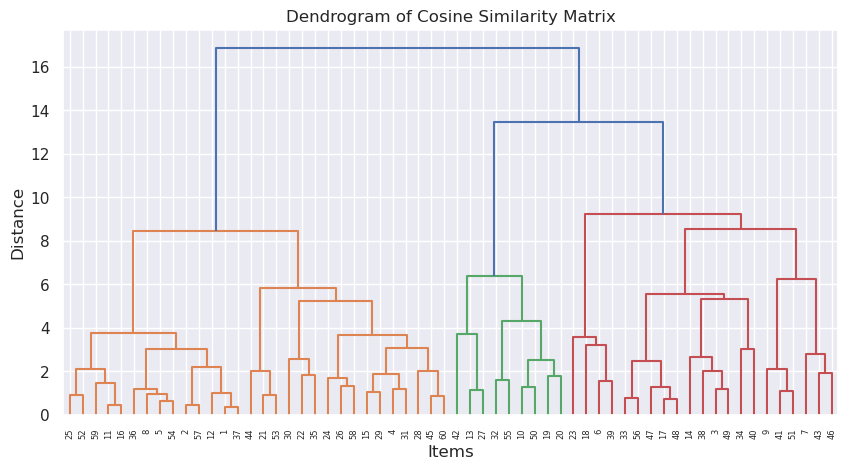

In [165]:
linkage_matrix = linkage(similarity_matrix, method='ward')

fig, ax = plt.subplots(figsize=(10, 5))
dendrogram(linkage_matrix, labels=range(1,61))
plt.title('Dendrogram of Cosine Similarity Matrix')
plt.xlabel('Items')
plt.ylabel('Distance')
plt.show()

In [166]:
cluster_assignments = fcluster(linkage_matrix, t=3, criterion = 'maxclust')

df_sherlock_segments_vader_vec['cluster'] = cluster_assignments
df_sherlock_segments_vader = pd.merge(df_sherlock_segments_vader, df_sherlock_segments_vader_vec[['title', 'cluster']], on='title', how='left')
df_sherlock_pivot = df_sherlock_segments_vader[['title', 'segment_num', 'avg_compound_score', 'cluster']]

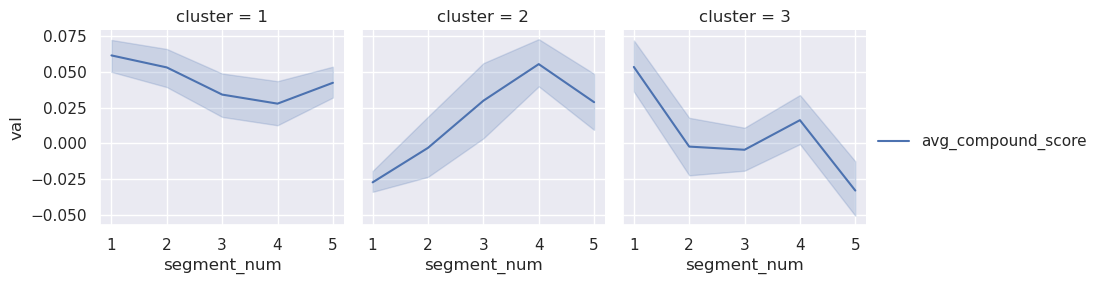

In [167]:
df_sherlock_pivot = pd.melt(df_sherlock_pivot, id_vars=['segment_num','title', 'cluster'], var_name='var', value_name= 'val')
fg = sns.FacetGrid(df_sherlock_pivot, col='cluster')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='var')

fg.add_legend()


In [ ]:
df_sherlock_pivot_cluster1 = df_sherlock_pivot.loc[df_sherlock_pivot['cluster'] == 1]

df_sherlock_pivot_cluster2 = df_sherlock_pivot.loc[df_sherlock_pivot['cluster'] == 2]

df_sherlock_pivot_cluster3 = df_sherlock_pivot.loc[df_sherlock_pivot['cluster']== 3]

In [ ]:
fg = sns.FacetGrid(df_sherlock_pivot_cluster1, row='title')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='var')

fg.set(xticks = range(1, 6, 1))

fg.add_legend(bbox_to_anchor = (1.05, 0.5), loc='center left')

In [ ]:
fg = sns.FacetGrid(df_sherlock_pivot_cluster2, row='title')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='var')

fg.set(xticks = range(1, 6, 1))

fg.add_legend(bbox_to_anchor = (1.05, 0.5), loc='center left')

In [ ]:
fg = sns.FacetGrid(df_sherlock_pivot_cluster3, row='title')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='var')

fg.set(xticks = range(1, 6, 1))

fg.add_legend(bbox_to_anchor = (1.05, 0.5), loc='center left')

<h3> Named Entity Recogniton </h3>

In [19]:
def extract_entities(text):
    pos_tags = nltk.pos_tag(text)
    tree = nltk.ne_chunk(pos_tags)
    return tree

In [20]:
df_sherlock_segments_ner['entities'] = df_sherlock_segments_ner['segments_ner'].apply(extract_entities)

In [21]:
def count_entities(parse_tree, *labels):
    tree = parse_tree
    count = 0
    for subtree in tree.subtrees():
        if subtree.label() in labels:
            count += 1
    return count

In [22]:
df_sherlock_segments_ner['person_entity_count'] = df_sherlock_segments_ner['entities'].apply(lambda parse_tree: count_entities(parse_tree, 'PERSON'))

df_sherlock_segments_ner['location_entity_count'] = df_sherlock_segments_ner['entities'].apply(lambda parse_tree: count_entities(parse_tree, 'LOCATION', 'GPE', 'FACILITY'))

In [23]:
def most_common_entities(row, labels):
    tree = row
    entities = []
    for label in labels:
        entities.extend([subtree.leaves() for subtree in tree.subtrees(lambda t: t.label() == label)])
    flattened_entities = [item for sublist in entities for item in sublist]
    if flattened_entities:
        most_common_entity = max(set(flattened_entities), key=flattened_entities.count)
        return most_common_entity
    else:
        return ''

In [24]:
most_common_persons = df_sherlock_segments_ner['entities'].apply(lambda row: most_common_entities(row, ['PERSON']))

In [25]:
most_common_persons.value_counts().nlargest(10)

entities
(Holmes, NNP)      119
(Mr., NNP)          49
(Watson, NNP)       27
(Sir, NNP)           7
(Von, NNP)           4
(Ferguson, NNP)      4
(Godfrey, NNP)       4
(Lestrade, NNP)      3
(Mycroft, NNP)       3
(Straker, NNP)       3
Name: count, dtype: int64

In [26]:
most_common_locations = df_sherlock_segments_ner['entities'].apply(lambda row: most_common_entities(row, ['LOCATION', 'GPE', 'FACILITY']))

In [27]:
most_common_locations.value_counts().nlargest(10)

entities
(London, NNP)     57
(Holmes, NNP)     22
(England, NNP)    20
(Street, NNP)      7
(American, JJ)     5
(Norwood, NNP)     4
(British, JJ)      4
(English, NNP)     4
(German, JJ)       4
(Colonel, NNP)     4
Name: count, dtype: int64

In [30]:
df_sherlock_segments_ner = min_max_scale_column(df_sherlock_segments_ner, 'person_entity_count_norm', 'person_entity_count', 'text_prepro_ner')

df_sherlock_segments_ner = min_max_scale_column(df_sherlock_segments_ner, 'location_entity_count_norm', 'location_entity_count', 'text_prepro_ner')

In [31]:
summary_stats_ner = df_sherlock_segments_ner[['segment_num', 'person_entity_count_norm', 'location_entity_count_norm']].groupby('segment_num').agg(['mean', 'std'])

<Axes: xlabel='segment_num', ylabel="('person_entity_count_norm', 'mean')">

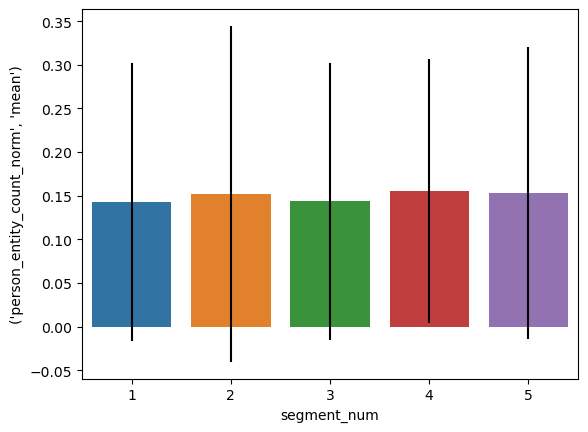

In [35]:
sns.barplot(x=summary_stats_ner.index, y=summary_stats_ner[('person_entity_count_norm', 'mean')], 
            yerr=summary_stats_ner[('person_entity_count_norm', 'std')])

<Axes: xlabel='segment_num', ylabel="('location_entity_count_norm', 'mean')">

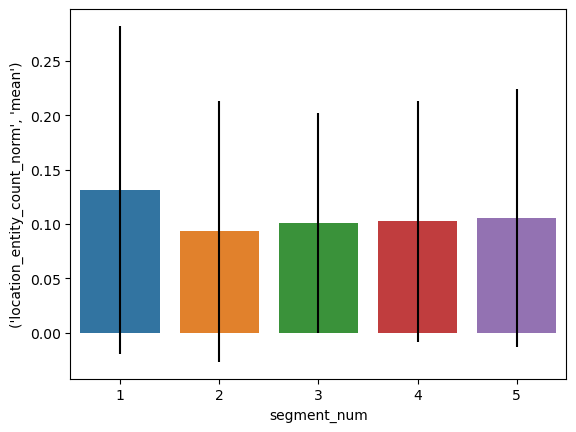

In [37]:
sns.barplot(x=summary_stats_ner.index, y=summary_stats_ner[('location_entity_count_norm', 'mean')], 
            yerr=summary_stats_ner[('location_entity_count_norm', 'std')])

<Axes: xlabel='segment_num', ylabel='value'>

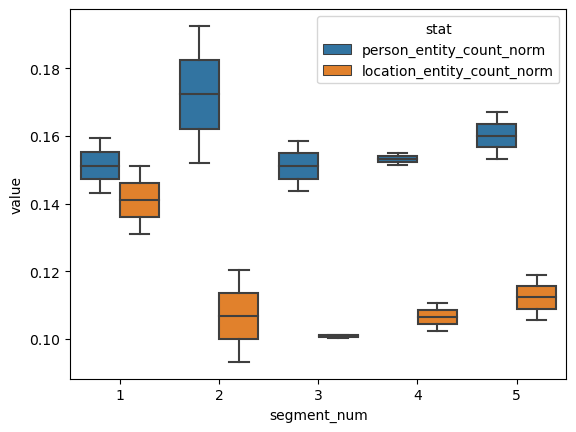

In [38]:
summary_stats_ner = summary_stats_ner.reset_index()

summary_stats_ner = pd.melt(summary_stats_ner, id_vars=['segment_num'], var_name='stat', value_name='value')

summary_stats_ner = summary_stats_ner.drop(index=summary_stats_ner[(summary_stats_ner['stat'] == 'level_0') | summary_stats_ner['stat'] =='index'].index)

sns.boxplot(data = summary_stats_ner, x='segment_num', y='value', hue='stat')

In [41]:
ls_anova = group_df(df_sherlock_segments_ner, 'person_entity_count_norm')

fvalue_person, pvalue_person = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for person entities (fvalue, pvalue): {}, {}'.format(fvalue_person, pvalue_person))

Results for ANOVA test for person entities (fvalue, pvalue): 0.06674727209797983, 0.9917985246195093


In [42]:
ls_anova = group_df(df_sherlock_segments_ner, 'location_entity_count_norm')

fvalue_location, pvalue_location = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for location entities (fvalue, pvalue): {}, {}'.format(fvalue_location, pvalue_location))

Results for ANOVA test for location entities (fvalue, pvalue): 0.8471628687505018, 0.49624403125515426


<Axes: xlabel='plot_element', ylabel='value'>

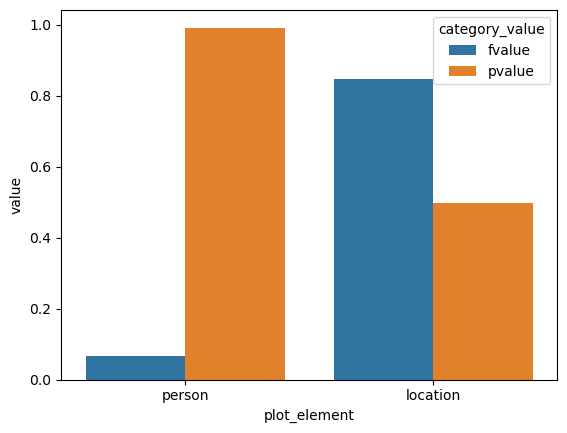

In [43]:
col1 = [fvalue_person, fvalue_location, pvalue_person, pvalue_location]
col2 = ['person', 'location', 'person', 'location']
col3 = ['fvalue', 'fvalue', 'pvalue', 'pvalue']

df_dict = {'value': col1, 'plot_element': col2, 'category_value': col3}

df_anova_ner = pd.DataFrame(df_dict)

sns.barplot(data = df_anova_ner, x='plot_element', y ='value', hue = 'category_value')

In [47]:
df_sherlock_segments_ner_vec = df_sherlock_segments_ner[['title', 'person_entity_count_norm', 'location_entity_count_norm']]

df_sherlock_segments_ner_vec = df_sherlock_segments_ner_vec.groupby('title').agg(lambda x: x.tolist())

df_sherlock_segments_ner_vec['vector'] = df_sherlock_segments_ner_vec.apply(lambda row: [val for sublist in row.values for val in sublist], axis=1)

df_sherlock_segments_ner_vec.reset_index(inplace=True)

df_sherlock_segments_ner_vec = df_sherlock_segments_ner_vec[['title', 'vector']]

matrix_vec = np.array(df_sherlock_segments_ner_vec['vector'].tolist())

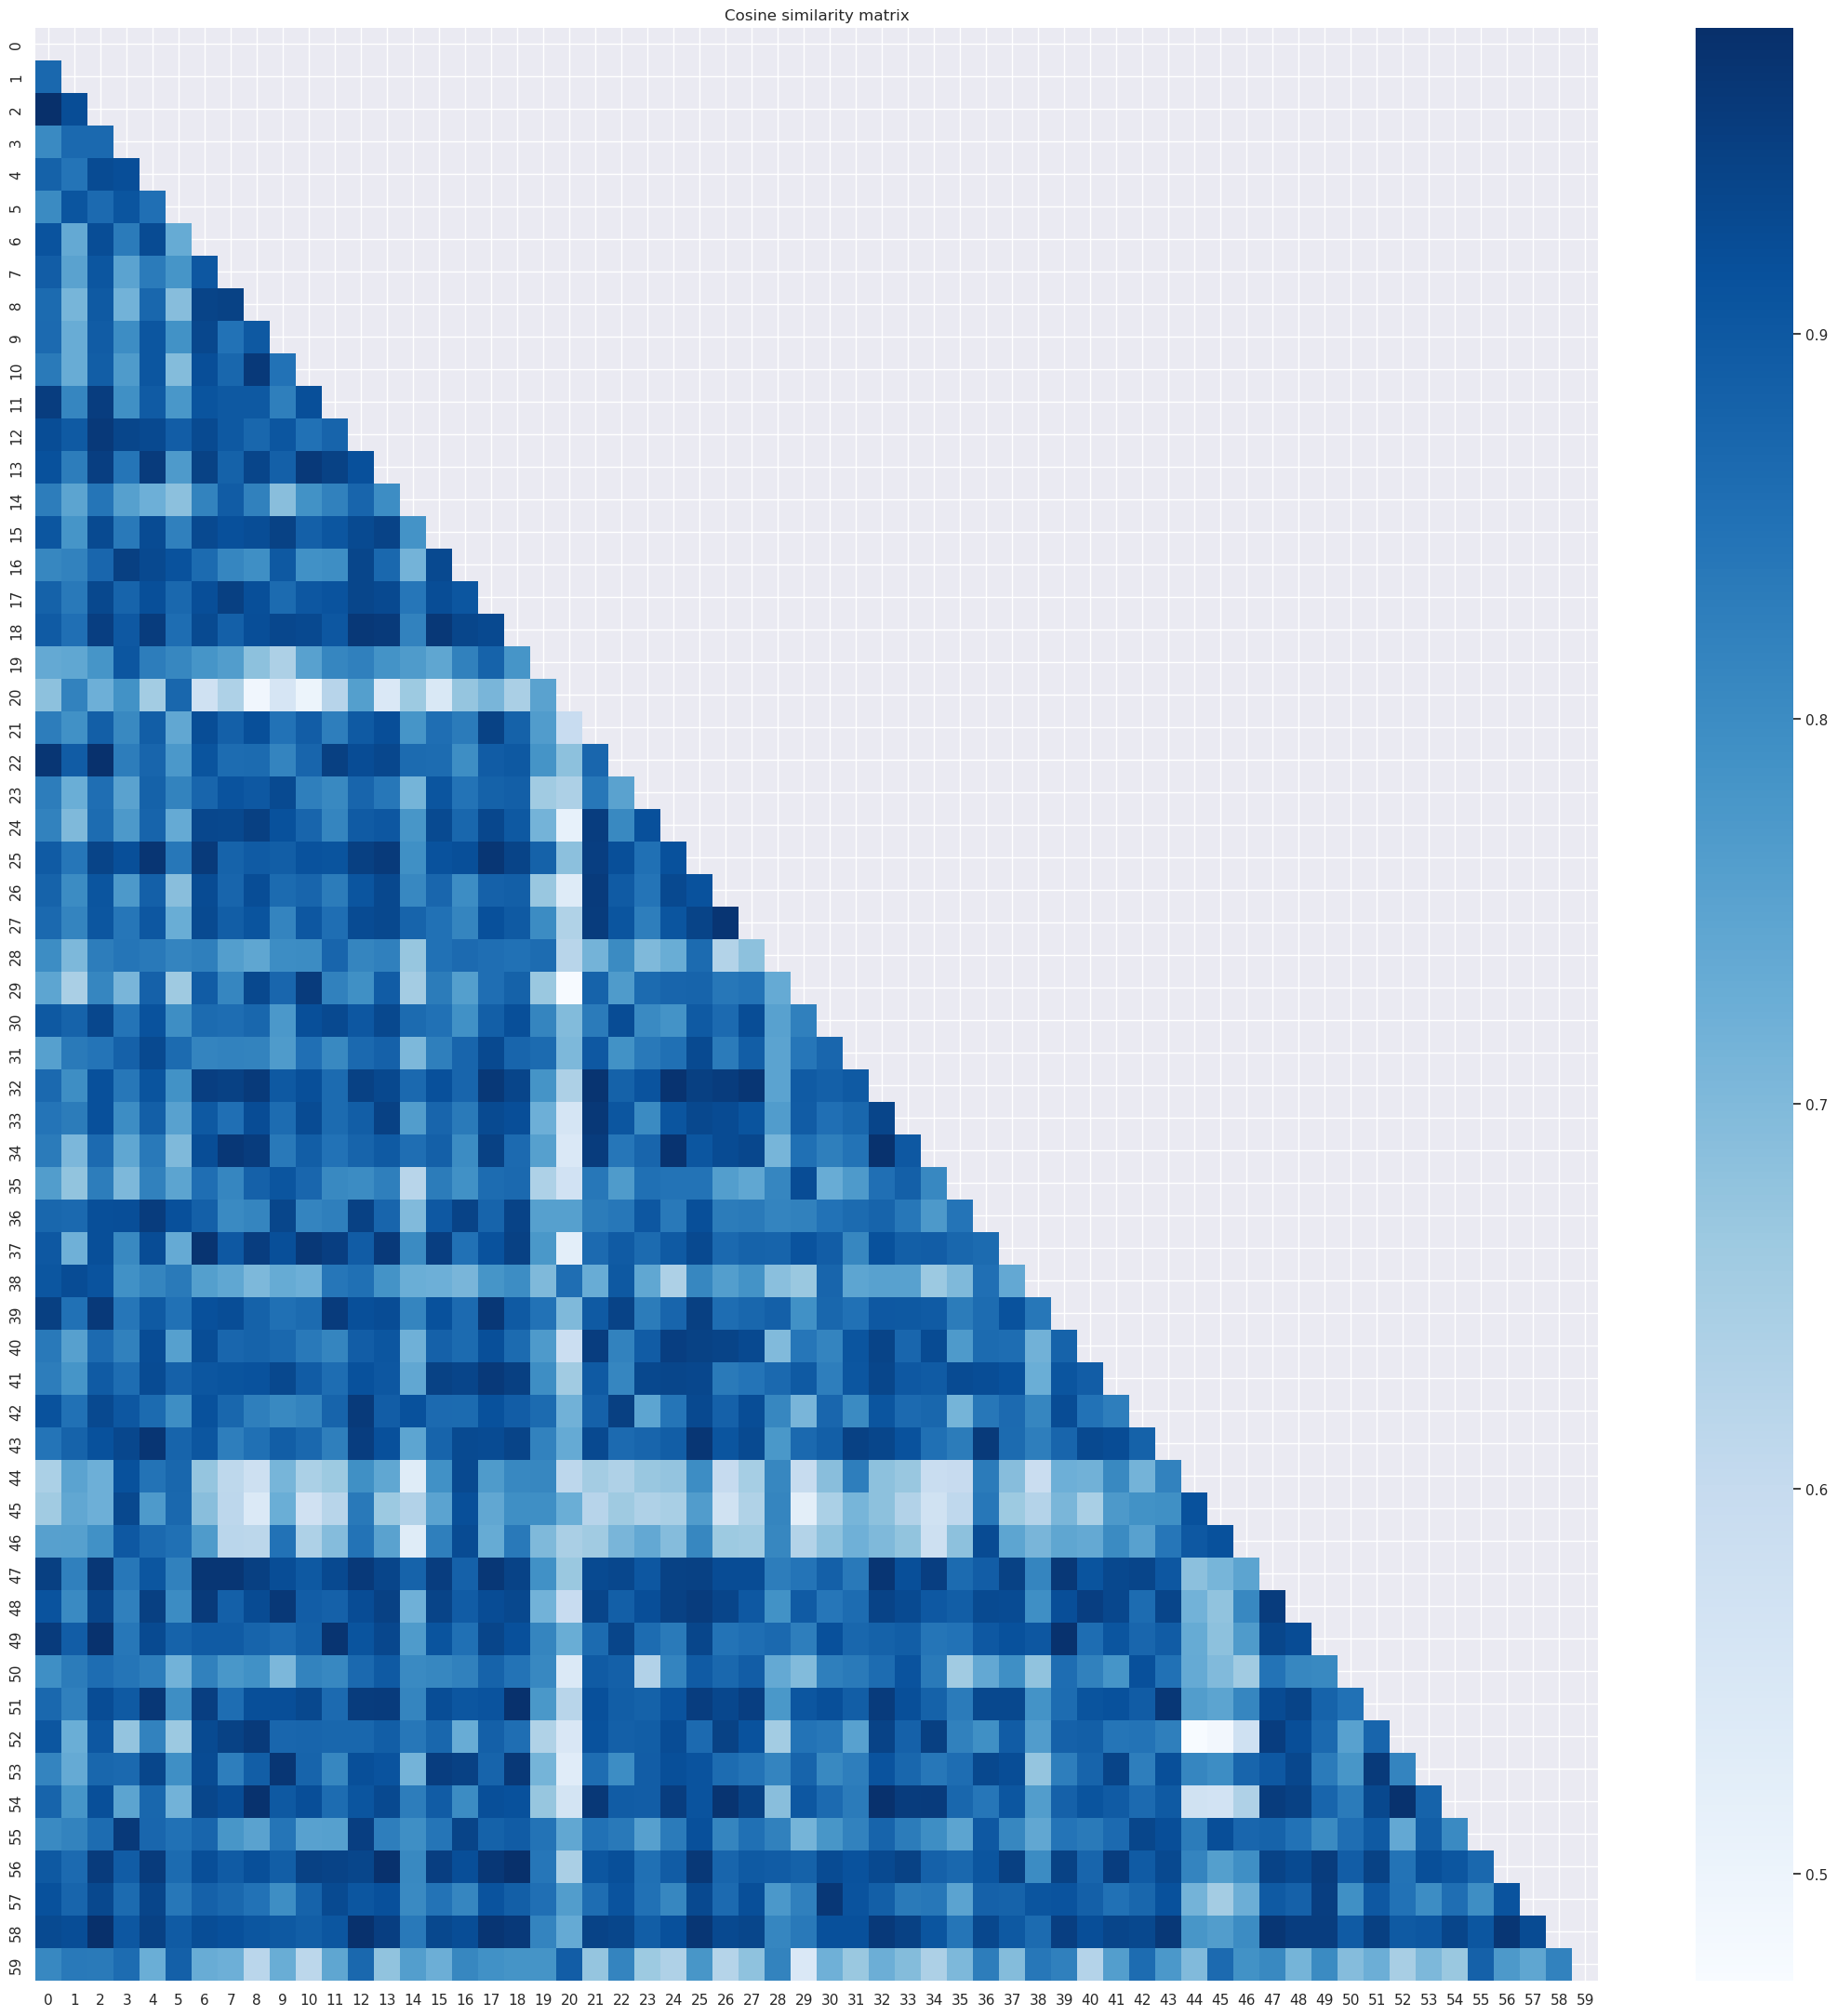

In [48]:
similarity_matrix = cosine_similarity(matrix_vec)
mask = np.triu(np.ones_like(similarity_matrix, dtype=bool))

sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(similarity_matrix, annot=False, cmap='Blues', mask=mask, ax=ax)
plt.subplots_adjust(left=0.25, bottom=0.25, right=0.95, top=0.95)
plt.title('Cosine similarity matrix')
plt.show()

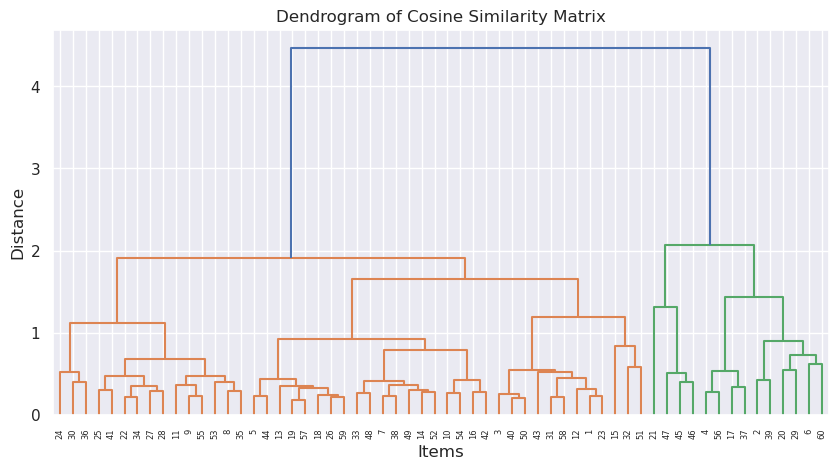

In [49]:
linkage_matrix = linkage(similarity_matrix, method='ward')

fig, ax = plt.subplots(figsize=(10, 5))
dendrogram(linkage_matrix, labels=range(1,61))
plt.title('Dendrogram of Cosine Similarity Matrix')
plt.xlabel('Items')
plt.ylabel('Distance')
plt.show()

In [50]:
cluster_assignments = fcluster(linkage_matrix, t=2, criterion = 'maxclust')

df_sherlock_segments_ner_vec['cluster'] = cluster_assignments

df_sherlock_segments_ner = pd.merge(df_sherlock_segments_ner, df_sherlock_segments_ner_vec[['title', 'cluster']], on='title', how='left')

df_sherlock_pivot = df_sherlock_segments_ner[['title', 'segment_num', 'person_entity_count_norm', 'location_entity_count_norm', 'cluster']]

df_sherlock_pivot = pd.melt(df_sherlock_pivot, id_vars=['segment_num','title', 'cluster'], var_name='var', value_name= 'val')

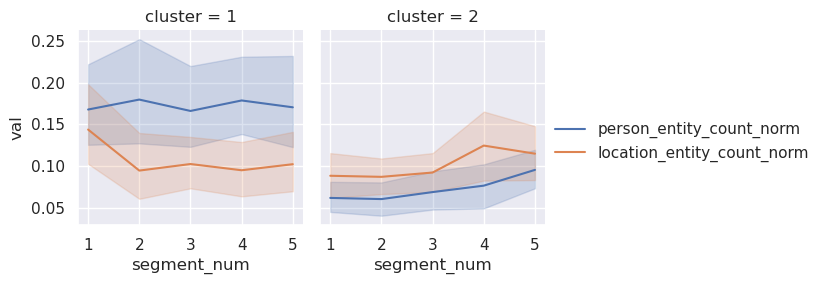

In [52]:
fg = sns.FacetGrid(df_sherlock_pivot, col='cluster')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='var')

fg.set(xticks = range(1, 6, 1))

fg.add_legend()

In [ ]:
df_sherlock_pivot_cluster1 = df_sherlock_pivot.loc[df_sherlock_pivot['cluster'] == 1]

df_sherlock_pivot_cluster2 = df_sherlock_pivot.loc[df_sherlock_pivot['cluster'] == 2]

In [ ]:
fg = sns.FacetGrid(df_sherlock_pivot_cluster1, row='title')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='var')

fg.set(xticks = range(1, 6, 1))

fg.add_legend(bbox_to_anchor = (1.05, 0.5), loc='center left')

In [ ]:
fg = sns.FacetGrid(df_sherlock_pivot_cluster2, row='title')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='var')

fg.set(xticks = range(1, 6, 1))

fg.add_legend(bbox_to_anchor = (1.05, 0.5), loc='center left')

<h2> Modeling </h2>

In [ ]:
"""TODO:
-apply dim reduction for better vis
-build classifier"""

In [ ]:
df_sub1 = df_sherlock_segments_narrative[['title', 'segment_num', 'staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm']]
df_sub2 = df_sherlock_segments_temp[['past_count_norm', 'present_count_norm', 'future_count_norm']]
df_sub3 = df_sherlock_segments_vader[['avg_compound_score']]
df_sub4 = df_sherlock_segments_ner[['person_entity_count_norm', 'location_count_norm']]

df_sherlock_modeling = pd.concat([df_sub1, df_sub2, df_sub3, df_sub4], axis=1)


In [45]:
df_sherlock_modeling_vec = df_sherlock_modeling[['title', 'staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm', 'past_count_norm', 'present_count_norm', 'future_count_norm', 'avg_compound_score', 'person_entity_count_norm', 'location_count_norm']]

df_sherlock_modeling_vec = df_sherlock_modeling_vec.groupby('title').agg(lambda x: x.tolist())

df_sherlock_modeling_vec['vector'] = df_sherlock_modeling_vec.apply(lambda row: [val for sublist in row.values for val in sublist], axis=1)
df_sherlock_modeling_vec.reset_index(inplace=True)
df_sherlock_modeling_vec = df_sherlock_modeling_vec[['title', 'vector']]  

In [48]:
vectorizer = CountVectorizer()

features_list = df_sherlock_modeling_vec['vector'].apply(lambda x: ' '.join([str(i) for i in x])).tolist()

sparse_matrix = vectorizer.fit_transform(features_list)

feature_array = sparse_matrix.toarray()

In [49]:
kmeans = KMeans(n_clusters=3)

kmeans.fit(feature_array)

/home/david/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)

In [50]:
labels = kmeans.labels_

df_sherlock_modeling_vec['cluster'] = labels

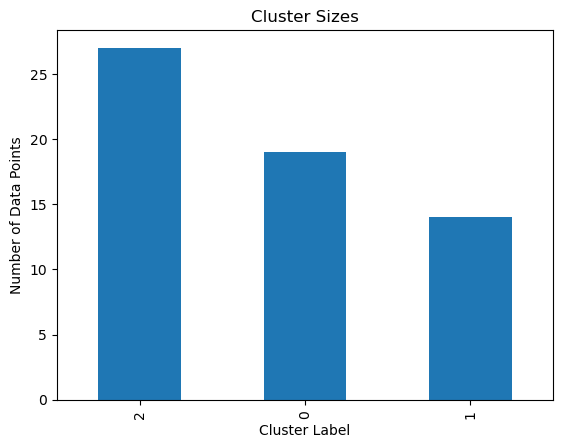

In [51]:
df_sherlock_modeling_vec['cluster'].value_counts().plot(kind='bar')
plt.title('Cluster Sizes')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Data Points')
plt.show()